# OLA Driver

**Column Profiling:**

1. MMMM-YY : Reporting Date (Monthly)
2. Driver\_ID : Unique id for drivers
3. Age : Age of the driver
4. Gender : Gender of the driver – Male : 0, Female: 1
5. City : City Code of the driver
6. Education\_Level : Education level – 0 for 10+ ,1 for 12+ ,2 for graduate
7. Income : Monthly average Income of the driver
8. Date Of Joining : Joining date for the driver
9. LastWorkingDate : Last date of working for the driver
10. Joining Designation : Designation of the driver at the time of joining
11. Grade : Grade of the driver at the time of reporting
12. Total Business Value : The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
13. Quarterly Rating : Quarterly rating of the driver: 1,2,3,4,5 (higher is better)

tenure
salary-revenue per driver
has neg business value

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from sklearn.impute import KNNImputer
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
import os

In [2]:
os.environ['PYSPARK_PIN_THREAD'] = 'false'

spark = SparkSession.builder \
    .appName("OLA") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.shuffle.partitions", 1) \
    .config("spark.network.timeout", "120s") \
    .config("spark.executor.heartbeatInterval", "10s") \
    .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:1.0.4,org.mlflow:mlflow-spark_2.13:2.15.1")   \
    .master("local[16]") \
    .getOrCreate();

:: loading settings :: url = jar:file:/Users/gautamnaik/anaconda3/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/gautamnaik/.ivy2/cache
The jars for the packages stored in: /Users/gautamnaik/.ivy2/jars
com.microsoft.azure#synapseml_2.12 added as a dependency
org.mlflow#mlflow-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-6be29ac3-8555-4ca0-87e6-486858f2886c;1.0
	confs: [default]
	found com.microsoft.azure#synapseml_2.12;1.0.4 in central
	found com.microsoft.azure#synapseml-core_2.12;1.0.4 in central
	found org.apache.spark#spark-avro_2.12;3.4.1 in central
	found org.tukaani#xz;1.9 in central
	found commons-lang#commons-lang;2.6 in central
	found org.scalactic#scalactic_2.12;3.2.14 in central
	found org.scala-lang#scala-reflect;2.12.15 in central
	found io.spray#spray-json_2.12;1.3.5 in central
	found com.jcraft#jsch;0.1.54 in central
	found org.apache.httpcomponents.client5#httpclient5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpcore5;5.1.3 in central
	found org.apache.httpcomponents.core5#httpco

In [3]:
spark.sparkContext.setLogLevel("ERROR")
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [15]:
spark_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .csv("./ola_driver_scaler.csv")
spark_df.cache();

In [16]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- MMM-YY: string (nullable = true)
 |-- Driver_ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Education_Level: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Dateofjoining: string (nullable = true)
 |-- LastWorkingDate: string (nullable = true)
 |-- Joining Designation: integer (nullable = true)
 |-- Grade: integer (nullable = true)
 |-- Total Business Value: integer (nullable = true)
 |-- Quarterly Rating: integer (nullable = true)



In [17]:
spark_df = spark_df.drop('_c0');
spark_df.show();

+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|  MMM-YY|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|
+--------+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+
|01/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             2381060|               2|
|02/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|           NULL|                  1|    1|             -665480|               2|
|03/01/19|        1| 28|     0| C23|              2| 57387|     24/12/18|       03/11/19|                  1|    1|                   0|               2|
|11/01/20|        2| 31|     0|  C7|              2| 67016|     11/06/20|   

In [18]:
spark_df.select([sf.count(sf.when(sf.isnull(c), c)).alias(c) for c in spark_df.columns]).toPandas().T

,0
MMM-YY,0
Driver_ID,0
Age,61
Gender,52
City,0
Education_Level,0
Income,0
Dateofjoining,0
LastWorkingDate,17488
Joining Designation,0


# Data Cleaning

In [18]:
spark_df = spark_df.withColumn("reporting_month_year", sf.to_date(spark_df["MMM-YY"], "MM/dd/yy")).drop("MMM-YY")
spark_df = spark_df.withColumn("Dateofjoining", sf.to_date(spark_df["Dateofjoining"], "dd/MM/yy"))
spark_df = spark_df.withColumn("LastWorkingDate", sf.to_date(spark_df["LastWorkingDate"], "dd/MM/yy"))
spark_df = spark_df.withColumn("Quarter", sf.quarter(spark_df["reporting_month_year"]))

In [19]:
spark_df=spark_df.dropDuplicates()

In [29]:
spark_df.filter(sf.col("Age").isNull()).show()

+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID| Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+----+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|       20|NULL|     1| C19|              0| 40342|   2019-10-25|           NULL|                  3|    3|                   0|               1|          2020-02-01|      1|
|       22|NULL|     0| C10|              2| 31224|   2018-05-25|           NULL|                  1|    1|              200000|               3|          2019-10-01|      4|
|       24|NULL|     0| C24|              2| 76308|   2018-05-25|           NULL|                  1|    2|              2032

In [20]:
spark_df.filter("Driver_ID == 2").sort("reporting_month_year").show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-11-01|      4|
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-12-01|      4|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+---

In [22]:
window_spec = Window.partitionBy("Driver_ID")

spark_df=spark_df.withColumns({
    "Age":  sf.coalesce(sf.col("Age"), sf.first("Age", True).over(window_spec)),
    "Gender":  sf.coalesce(sf.col("Gender"), sf.first("Age", True).over(window_spec)),
    "LastWorkingDate":  sf.coalesce(sf.col("LastWorkingDate"), sf.first("LastWorkingDate", True).over(window_spec)),
    "Churned":  sf.when(sf.col("LastWorkingDate").isNotNull(), 1).otherwise(0),
    "Had_Negative_Business":  sf.when(sf.col("Total Business Value") > 0, 1).otherwise(0)
})

In [51]:
spark_df.createOrReplaceTempView("ola")

In [35]:
spark.sql(""" 
    select 
          Driver_Id
          , max(reporting_month_year) as max_reporting_month_year
          , max(Dateofjoining) as max_Dateofjoining
          , max(LastWorkingDate) as max_LastWorkingDate
        from ola 
        group by Driver_Id
          having max_LastWorkingDate < max_Dateofjoining
""").show()

+---------+------------------------+-----------------+-------------------+
|Driver_Id|max_reporting_month_year|max_Dateofjoining|max_LastWorkingDate|
+---------+------------------------+-----------------+-------------------+
|        5|              2019-03-01|       2019-09-01|         2019-07-03|
|       18|              2019-05-01|       2019-09-01|         2019-04-30|
|       35|              2020-05-01|       2020-07-03|         2020-05-05|
|       59|              2019-03-01|       2019-06-01|         2019-03-28|
|       82|              2020-08-01|       2020-11-04|         2020-07-29|
|      102|              2019-03-01|       2019-05-01|         2019-03-21|
|      108|              2020-06-01|       2020-09-01|         2020-02-06|
|      118|              2020-09-01|       2020-10-03|         2020-09-15|
|      121|              2020-05-01|       2020-07-03|         2020-05-24|
|      139|              2019-12-01|       2019-10-31|         2019-05-12|
|      147|              

In [27]:
spark.sql("""
          select 
          Driver_ID
          , max(`Quarterly Rating`) as max_qr
          , min(`Quarterly Rating`) as min_qr
          , avg(`Quarterly Rating`) as avg_qr 
          , count(*) as count_qr
          from ola 
          group by Driver_ID 
          order by count_qr desc
           """).show()

+---------+------+------+------+--------+
|Driver_ID|max_qr|min_qr|avg_qr|count_qr|
+---------+------+------+------+--------+
|       56|     4|     2| 2.875|      24|
|       60|     4|     2|   3.5|      24|
|      486|     3|     1| 1.875|      24|
|       63|     3|     1| 1.875|      24|
|     1472|     3|     1|  1.75|      24|
|       67|     3|     1|   2.5|      24|
|     1664|     2|     2|   2.0|      24|
|       68|     4|     3|  3.25|      24|
|     2168|     3|     2| 2.625|      24|
|       77|     4|     2|   3.0|      24|
|     2545|     3|     1|   2.0|      24|
|       78|     4|     2| 2.625|      24|
|       25|     4|     3|  3.75|      24|
|      112|     4|     2| 2.875|      24|
|      173|     4|     2|  2.75|      24|
|      115|     3|     2| 2.125|      24|
|     1612|     4|     1|  2.25|      24|
|      117|     4|     2|   2.5|      24|
|      199|     4|     2|  3.25|      24|
|      140|     3|     2| 2.625|      24|
+---------+------+------+------+--

In [53]:
spark_df.filter("`Total Business Value` = 0").show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+---------------------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|Churned|Had_Negative_Business|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+---------------------+
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|                   0|               2|          2019-03-01|      1|      1|                    0|
|        2| 31|     0|  C7|              2| 67016|   2020-06-11|           NULL|                  2|    2|                   0|               1|          2020-11-01|      4|      0|   

In [28]:
spark_df.select(sf.max("LastWorkingDate")).show()

+--------------------+
|max(LastWorkingDate)|
+--------------------+
|          2020-12-28|
+--------------------+



In [29]:
spark_df.select(sf.max("reporting_month_year")).show()

+-------------------------+
|max(reporting_month_year)|
+-------------------------+
|               2020-12-01|
+-------------------------+



In [23]:
spark_df.columns

['Driver_ID',
 'Age',
 'Gender',
 'City',
 'Education_Level',
 'Income',
 'Dateofjoining',
 'LastWorkingDate',
 'Joining Designation',
 'Grade',
 'Total Business Value',
 'Quarterly Rating',
 'reporting_month_year',
 'Quarter',
 'Churned',
 'Had_Negative_Business']

In [24]:
agg_map=[
    sf.first("Dateofjoining").alias("Date_Of_Joining"),
    sf.sum("Total Business Value").alias("Total_Business_Value"),
    sf.sum("Had_Negative_Business").alias("Total_Had_Negative_Business"),
    sf.avg("Total Business Value").cast("int").alias("Avg_Business_Value"), 
    sf.max("reporting_month_year").alias("Last_Reporting_Month"),
    sf.max("Age").alias("Age"),
    sf.first("Gender").alias("Gender"),
    sf.first("Income").alias("Income"),
    sf.sum("Income").alias("Total_Income"),
    sf.first("Education_Level").alias("Education_Level"),
    sf.first("City").alias("City"),
    sf.first("Joining Designation").alias("Joining_Designation"),
    sf.min("Grade").alias("Min_Grade"),
    sf.max("Grade").alias("Max_Grade"),
    sf.round(sf.avg("Grade"), 1).alias("Avg_Grade"),    
    sf.mode("Grade").alias("Mode_Grade"),
    sf.min("Quarterly Rating").alias("Min_Quarterly_Rating"),
    sf.max("Quarterly Rating").alias("Max_Quarterly_Rating"),
    sf.round(sf.avg("Quarterly Rating"), 1).alias("Avg_Quarterly_Rating"),
    sf.mode("Quarterly Rating").alias("Mode_Quarterly_Rating"),
    sf.max("LastWorkingDate").alias("Last_Working_Date"),
    sf.max("churned").alias("Churned"),
]


merged_df = spark_df.groupBy("Driver_ID").agg(*agg_map)

default_date = "2020-12-31"

merged_df = merged_df.withColumn(
    "Tenure",
      sf.abs(
        sf.datediff(
            sf.when(sf.col("Last_Working_Date").isNull(), sf.lit(default_date)).otherwise(sf.col("Last_Working_Date")),
            sf.col("Date_Of_Joining")
        )
    )
)


merged_df=merged_df.withColumn("Date_Of_Joining_month", sf.month(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Date_Of_Joining_year", sf.year(merged_df["Date_Of_Joining"]))
merged_df=merged_df.withColumn("Is_Valuable_Driver", sf.when(merged_df["Total_Business_Value"] > merged_df["Total_Income"], 1).otherwise(0))

merged_df.show()

+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+-------------------+---------+---------+---------+----------+--------------------+--------------------+--------------------+---------------------+-----------------+-------+------+---------------------+--------------------+------------------+
|Driver_ID|Date_Of_Joining|Total_Business_Value|Total_Had_Negative_Business|Avg_Business_Value|Last_Reporting_Month|Age|Gender|Income|Total_Income|Education_Level|City|Joining_Designation|Min_Grade|Max_Grade|Avg_Grade|Mode_Grade|Min_Quarterly_Rating|Max_Quarterly_Rating|Avg_Quarterly_Rating|Mode_Quarterly_Rating|Last_Working_Date|Churned|Tenure|Date_Of_Joining_month|Date_Of_Joining_year|Is_Valuable_Driver|
+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+------------

In [32]:
spark_df.show()

+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+
|Driver_ID|Age|Gender|City|Education_Level|Income|Dateofjoining|LastWorkingDate|Joining Designation|Grade|Total Business Value|Quarterly Rating|reporting_month_year|Quarter|Churned|
+---------+---+------+----+---------------+------+-------------+---------------+-------------------+-----+--------------------+----------------+--------------------+-------+-------+
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|                   0|               2|          2019-03-01|      1|      1|
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|                  1|    1|             2381060|               2|          2019-01-01|      1|      1|
|        1| 28|     0| C23|              2| 57387|   2018-12-24|     2019-11-03|          

In [25]:
spark_df.write.parquet("ola_driver_cleaned.parquet", mode='overwrite')
merged_df.write.parquet("ola_driver_merged.parquet", mode='overwrite')

# EDA

In [27]:
ola_df = spark.read.parquet("ola_driver_cleaned.parquet")
merged_df = spark.read.parquet("ola_driver_merged.parquet")
ola_df.createOrReplaceTempView("ola_driver")
merged_df.createOrReplaceTempView("ola_driver_merged")
ola_df=ola_df.toPandas()
merged_df=merged_df.toPandas()

In [64]:
ola_df=pd.read_parquet("ola_driver_cleaned.parquet")
merged_df=pd.read_parquet("ola_driver_merged.parquet")

In [28]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Driver_ID,2381.0,1.397559e+03,8.061616e+02,1.0,695.0,1400.0,2100.0,2788.0
Total_Business_Value,2381.0,4.586742e+06,9.127115e+06,-1385530.0,0.0,817680.0,4173650.0,95331060.0
Total_Had_Negative_Business,2381.0,5.231415e+00,6.956693e+00,0.0,0.0,2.0,7.0,24.0
Avg_Business_Value,2381.0,3.120852e+05,4.495704e+05,-197932.0,0.0,150624.0,429498.0,3972127.0
Age,2381.0,3.366317e+01,5.983375e+00,21.0,29.0,33.0,37.0,58.0
Gender,2381.0,4.103318e-01,4.919972e-01,0.0,0.0,0.0,1.0,1.0
Income,2381.0,5.921868e+04,2.828788e+04,10747.0,39104.0,55276.0,75765.0,188418.0
Total_Income,2381.0,5.267603e+05,6.231633e+05,10883.0,139895.0,292980.0,651456.0,4522032.0
Education_Level,2381.0,1.007560e+00,8.162900e-01,0.0,0.0,1.0,2.0,2.0
Joining_Designation,2381.0,1.820244e+00,8.414334e-01,1.0,1.0,2.0,2.0,5.0


In [29]:
merged_df[merged_df["Tenure"]==0]

,Driver_ID,Date_Of_Joining,Total_Business_Value,Total_Had_Negative_Business,Avg_Business_Value,Last_Reporting_Month,Age,Gender,Income,Total_Income,...,Min_Quarterly_Rating,Max_Quarterly_Rating,Avg_Quarterly_Rating,Mode_Quarterly_Rating,Last_Working_Date,Churned,Tenure,Date_Of_Joining_month,Date_Of_Joining_year,Is_Valuable_Driver
220,264,2020-12-18,0,0,0,2020-12-01,25,0,49439,49439,...,1,1,1.0,1,2020-12-18,1,0,12,2020,0
1026,1207,2020-12-04,0,0,0,2020-04-01,28,0,56498,56498,...,1,1,1.0,1,2020-12-04,1,0,12,2020,0
1344,1581,2019-06-30,0,0,0,2019-07-01,29,0,25873,25873,...,1,1,1.0,1,2019-06-30,1,0,6,2019,0
2041,2397,2020-05-15,0,0,0,2020-05-01,38,1,47818,47818,...,1,1,1.0,1,2020-05-15,1,0,5,2020,0


## Outlier Check

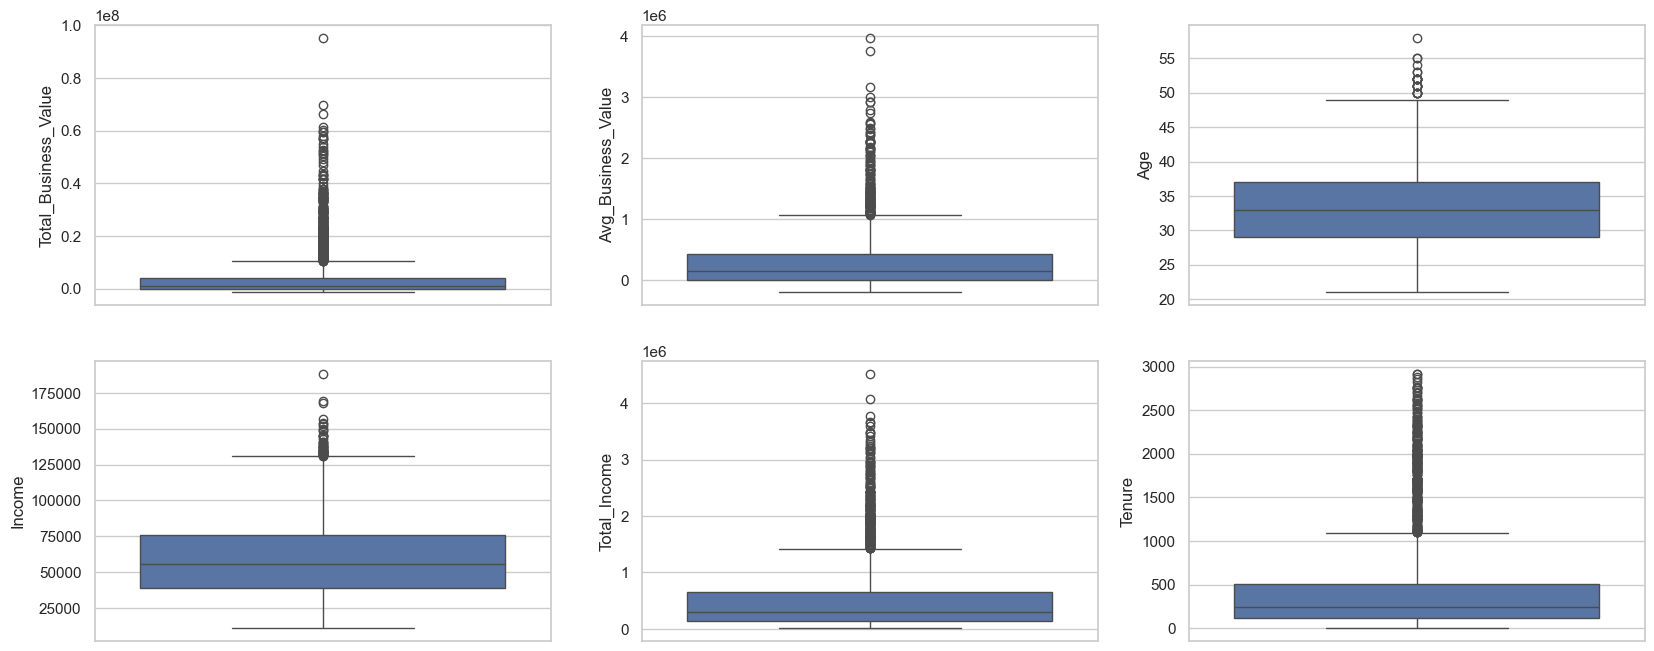

In [9]:
numerical_cols = ['Total_Business_Value', 'Avg_Business_Value', 'Age','Income', 'Total_Income', 'Tenure']

fig, ax = plt.subplots(2, 3, figsize=(20, 8))
for i, col in enumerate(numerical_cols):
    sns.boxplot(merged_df[col], ax=ax[i//3, i%3])

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see there are not any drastic outliers

## Univariate Analysis

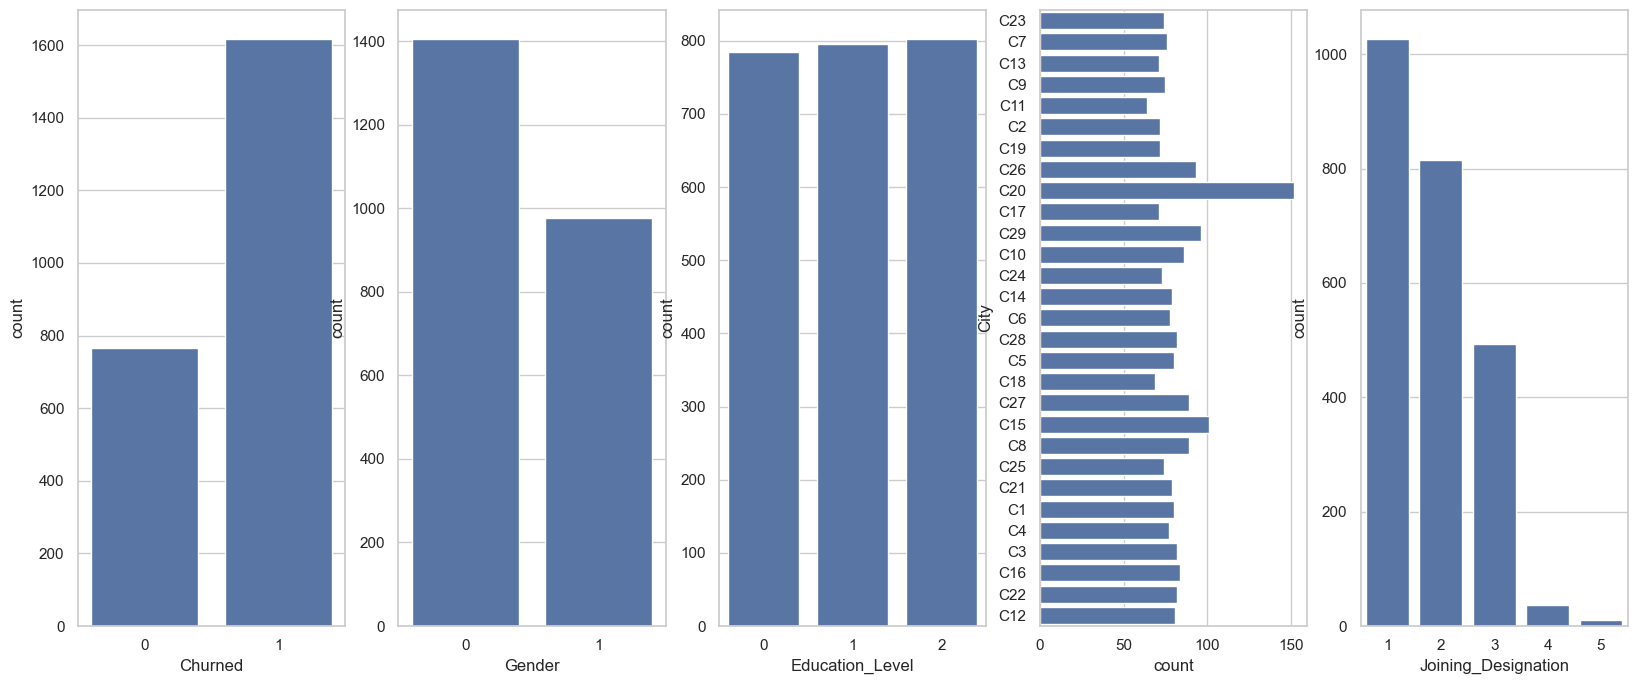

In [11]:
fig, ax = plt.subplots(1, 5, figsize=(20, 8))

sns.countplot(data=merged_df, x="Churned", ax=ax[0])
sns.countplot(data=merged_df, x="Gender", ax=ax[1])
sns.countplot(data=merged_df, x="Education_Level", ax=ax[2])
sns.countplot(data=merged_df, y="City", ax=ax[3])
sns.countplot(data=merged_df, x="Joining_Designation", ax=ax[4]);


<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- We can see that 1600 drivers have left

<Axes: xlabel='Tenure', ylabel='Count'>

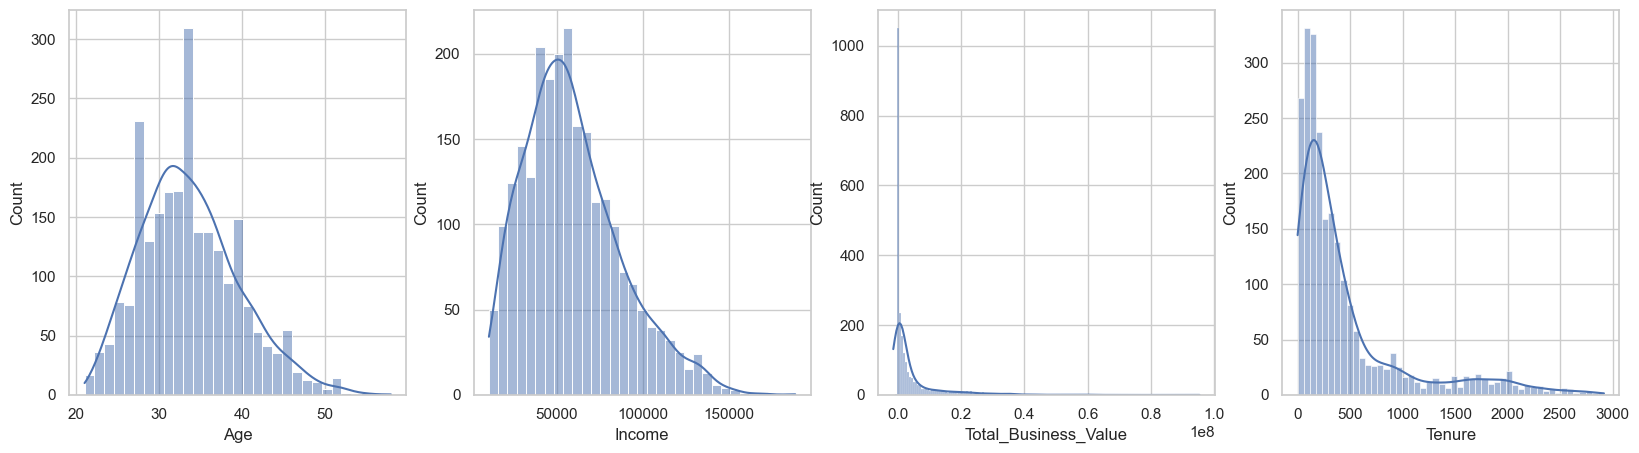

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.histplot(merged_df["Age"], kde=True, ax=ax[0])
sns.histplot(merged_df["Income"], kde=True, ax=ax[1])
sns.histplot(merged_df["Total_Business_Value"], kde=True, ax=ax[2])
sns.histplot(merged_df["Tenure"], kde=True, ax=ax[3]);

## Bivariate Analysis

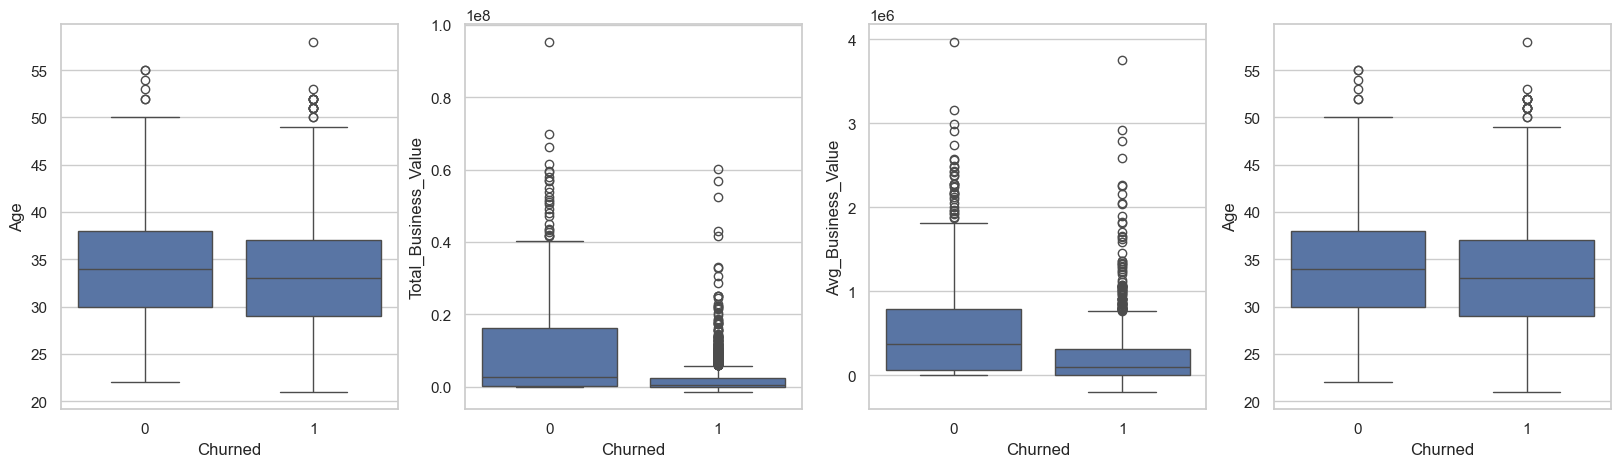

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Age", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Business_Value", ax=ax[1]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Business_Value", ax=ax[2]);
sns.boxplot(data=merged_df, x="Churned", y="Age", ax=ax[3]);

In [17]:
merged_df.columns

Index(['Driver_ID', 'Date_Of_Joining', 'Total_Business_Value',
       'Avg_Business_Value', 'Last_Reporting_Month', 'Age', 'Gender', 'Income',
       'Total_Income', 'Education_Level', 'City', 'Joining_Designation',
       'Min_Grade', 'Max_Grade', 'Avg_Grade', 'Mode_Grade',
       'Min_Quarterly_Rating', 'Max_Quarterly_Rating', 'Avg_Quarterly_Rating',
       'Mode_Quarterly_Rating', 'Last_Working_Date', 'Churned', 'Tenure'],
      dtype='object')

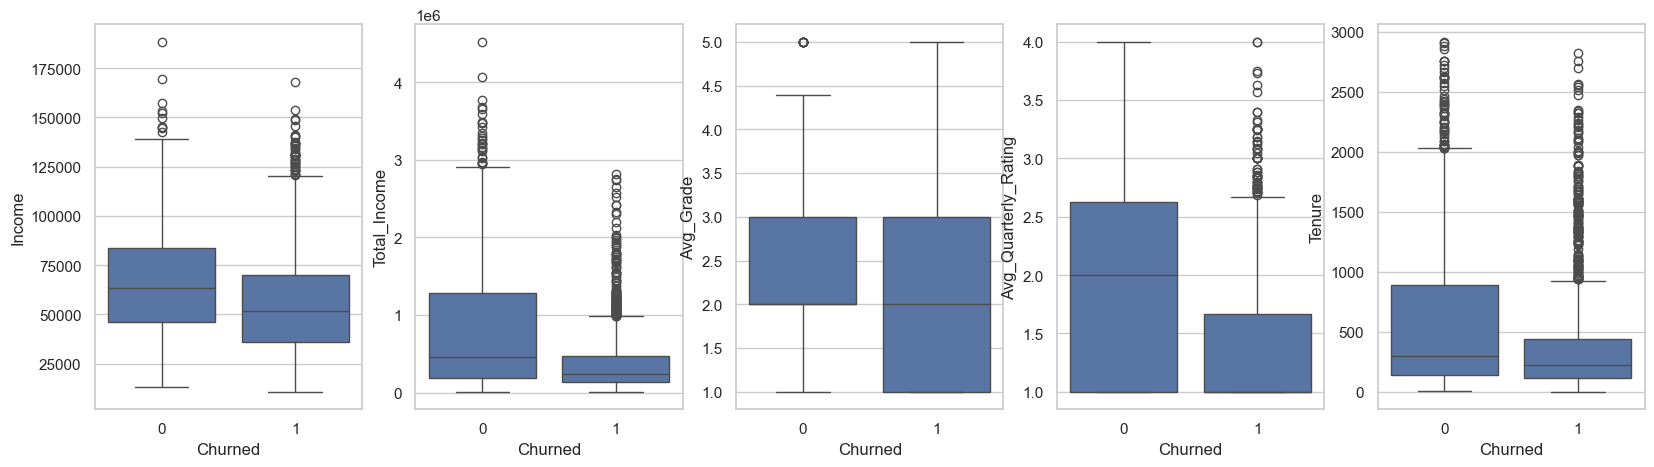

In [24]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))

sns.boxplot(data=merged_df, x="Churned", y="Income", ax=ax[0]);
sns.boxplot(data=merged_df, x="Churned", y="Total_Income", ax=ax[1]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Grade", ax=ax[2]);
sns.boxplot(data=merged_df, x="Churned", y="Avg_Quarterly_Rating", ax=ax[3]);
sns.boxplot(data=merged_df, x="Churned", y="Tenure", ax=ax[4]);

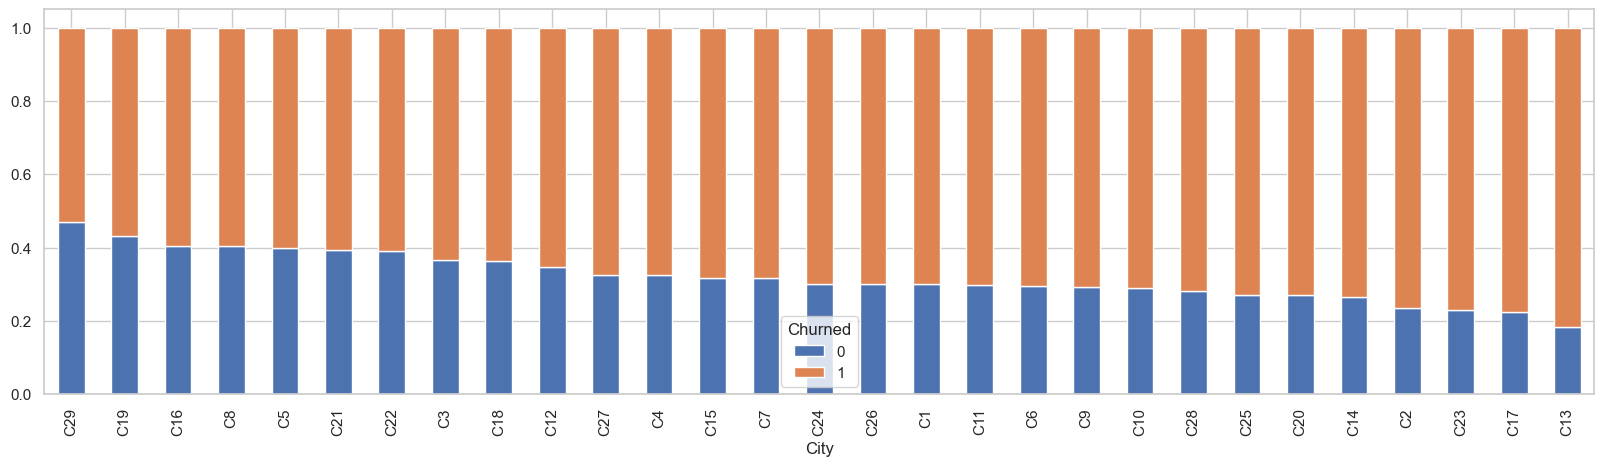

In [13]:
pd.crosstab(merged_df["City"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, figsize=(20, 5));



<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above plot shows the ratio of churned drivers in each city

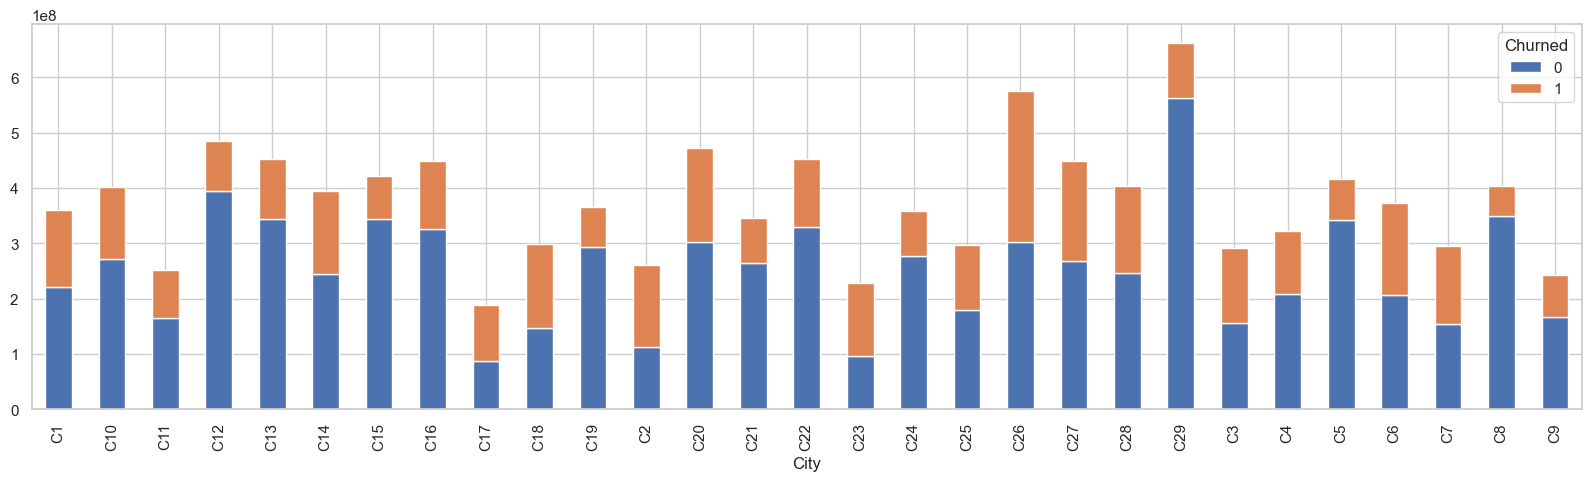

In [30]:
pd.pivot_table(merged_df, index="City", columns="Churned", values="Total_Business_Value", aggfunc="sum").plot(kind="bar", stacked=True, figsize=(20, 5));

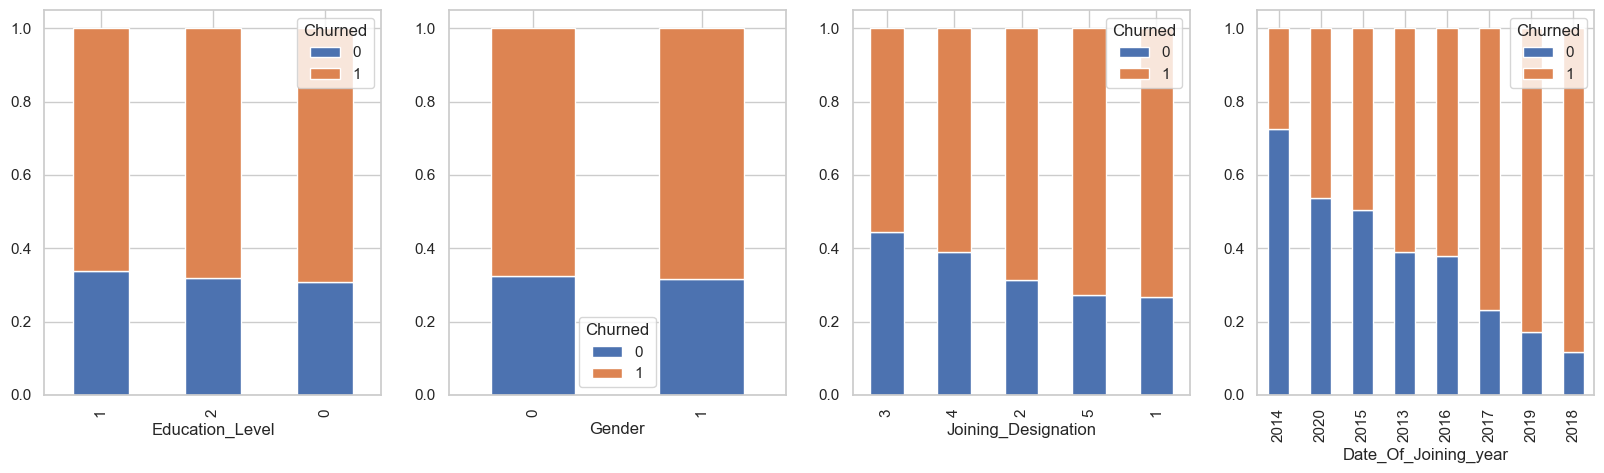

In [71]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

pd.crosstab(merged_df["Education_Level"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[0]);
pd.crosstab(merged_df["Gender"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[1]);
pd.crosstab(merged_df["Joining_Designation"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[2]);
pd.crosstab(merged_df["Date_Of_Joining_year"], merged_df["Churned"],  normalize="index").sort_values(1).plot(kind="bar", stacked=True, ax=ax[3]);



<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that Gender and Education level donot have significant effect on Churn
- From above plot we can see that Joining designation and Joining year have significant effect on churn

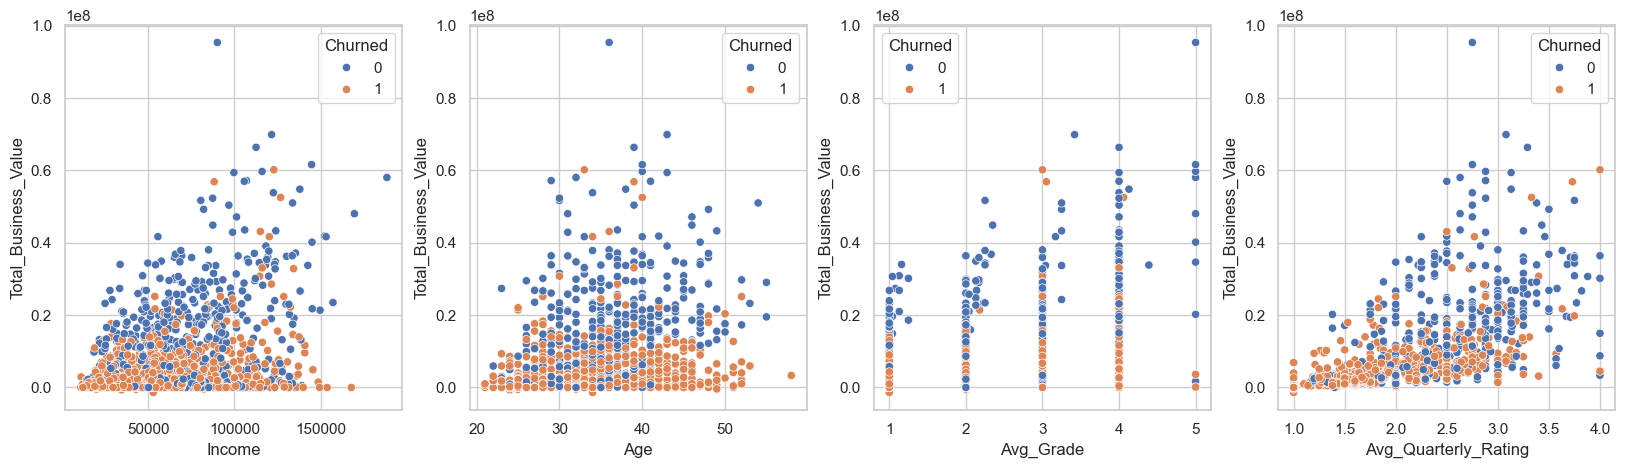

In [73]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))


sns.scatterplot(data=merged_df, x="Income", y="Total_Business_Value", hue="Churned", ax=ax[0]);
sns.scatterplot(data=merged_df, x="Age", y="Total_Business_Value", hue="Churned", ax=ax[1]);
sns.scatterplot(data=merged_df, x="Avg_Grade", y="Total_Business_Value", hue="Churned", ax=ax[2]);
sns.scatterplot(data=merged_df, x="Avg_Quarterly_Rating", y="Total_Business_Value", hue="Churned", ax=ax[3]);

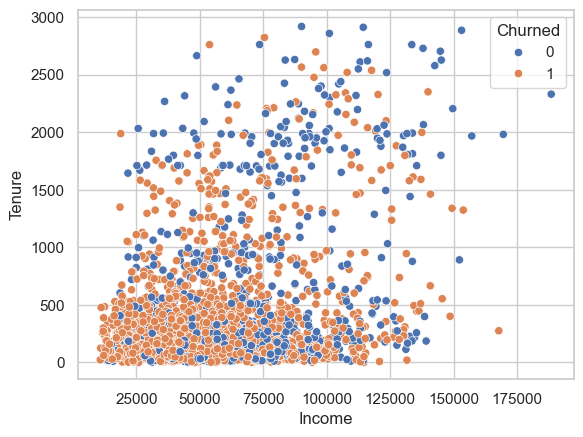

In [6]:
sns.scatterplot(data=merged_df, x="Income", y="Tenure", hue="Churned");

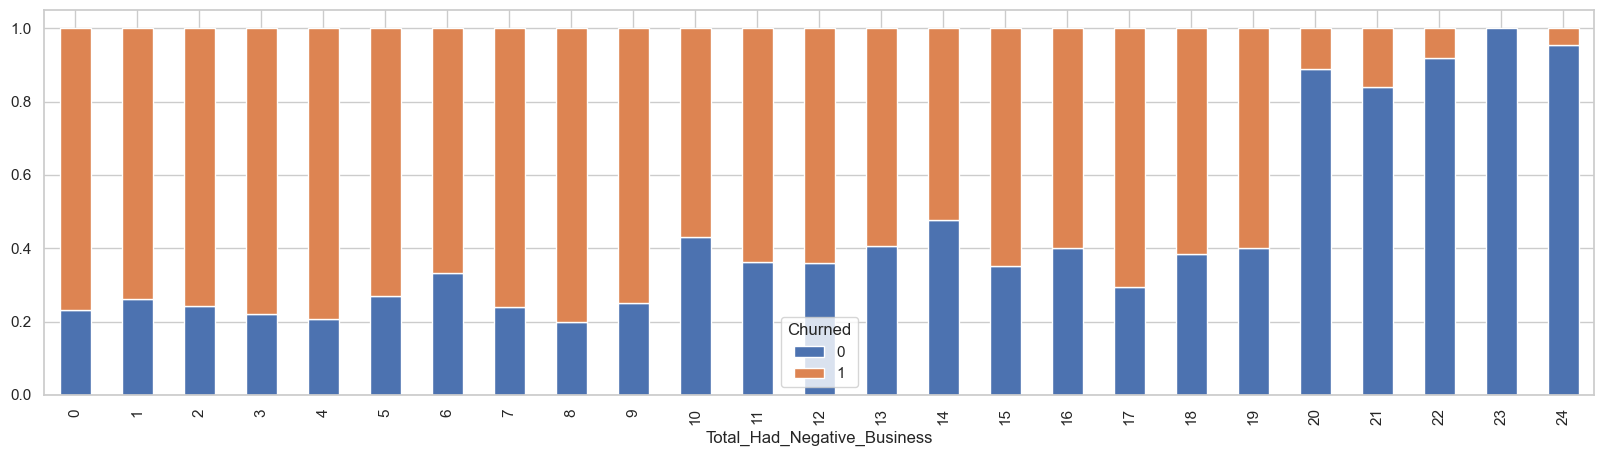

In [13]:
# sns.histplot(data=merged_df, x="Total_Had_Negative_Business", hue="Churned", kde=True);
pd.crosstab(merged_df["Total_Had_Negative_Business"], merged_df["Churned"],  normalize="index").plot(kind="bar", stacked=True, figsize=(20, 5));


In [14]:
merged_df["Avg_Grade"].value_counts()

Avg_Grade
2.00    844
1.00    741
3.00    602
4.00    129
5.00     21
3.25      5
2.25      5
2.17      4
2.13      4
1.13      3
2.04      3
1.04      3
1.25      2
2.33      1
3.04      1
1.08      1
2.06      1
4.06      1
1.16      1
3.17      1
4.13      1
2.14      1
2.23      1
3.05      1
2.18      1
4.39      1
3.42      1
2.35      1
Name: count, dtype: int64

In [ ]:
sns.scatterplot(data=merged_df, x="Total_Had_Negative_Business", y="Total_Business_Value", hue="Churned");

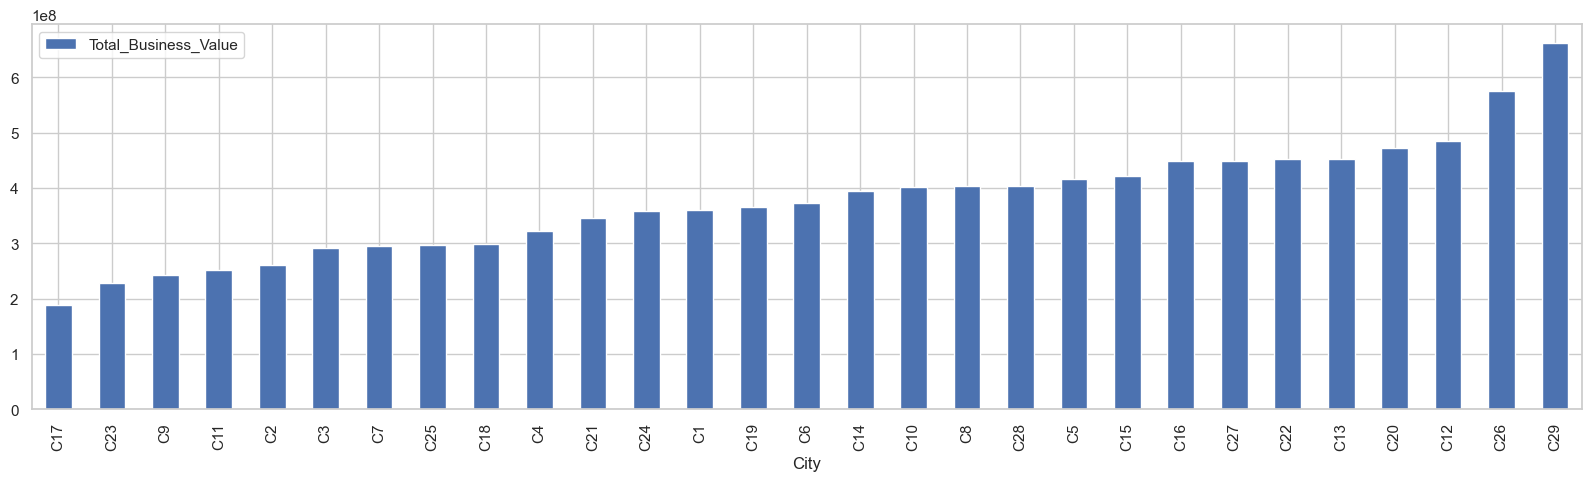

In [74]:
merged_df.groupby("City").agg({"Total_Business_Value": "sum"}).sort_values("Total_Business_Value").plot(kind="bar", figsize=(20, 5));

<b style='padding: 2px 8px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that C29 city has highest revenue

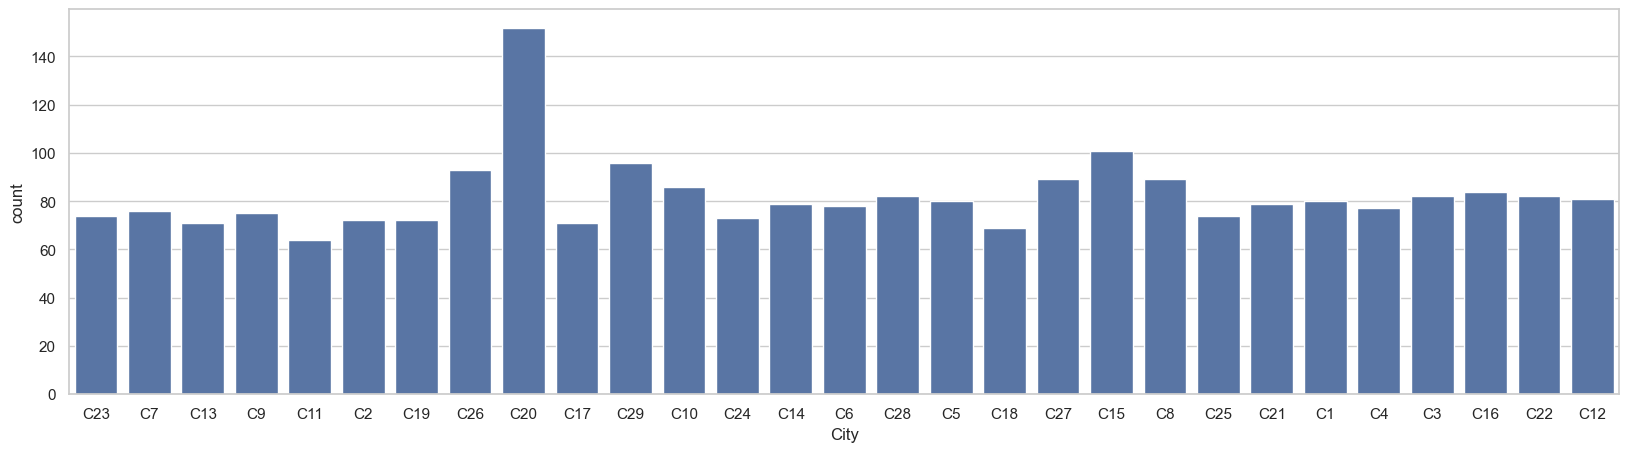

In [80]:
plt.figure(figsize=(20, 5))
sns.countplot(data=merged_df, x="City");

In [75]:
merged_df_corr = merged_df.select_dtypes(include=[np.number]).drop("Driver_ID", axis=1).corr()

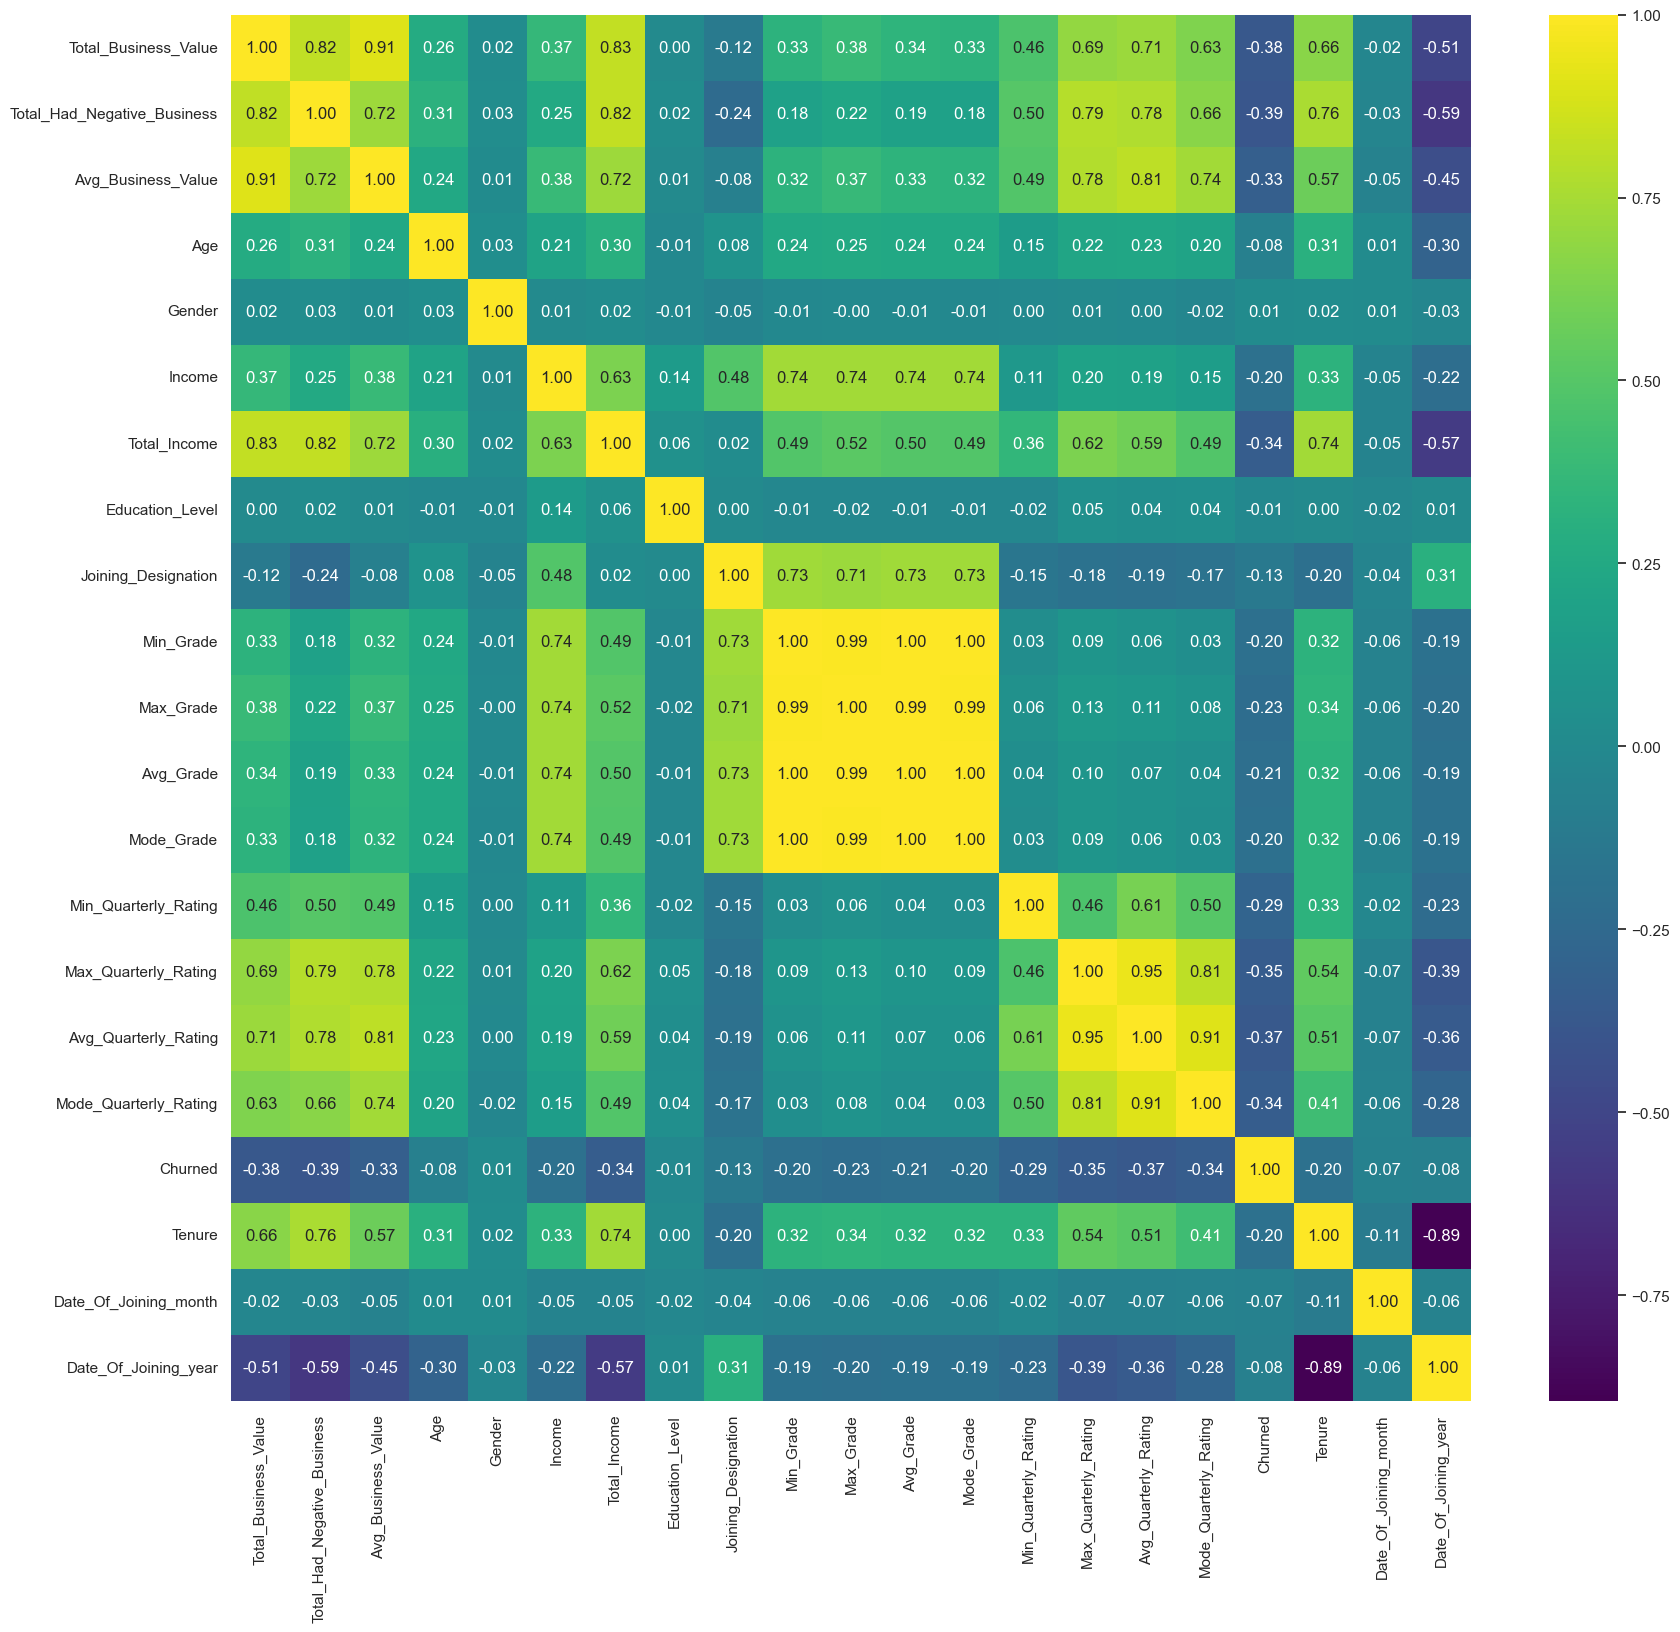

In [76]:
plt.figure(figsize=(20, 18))
sns.heatmap(merged_df_corr, annot=True, cmap="viridis", fmt=".2f");

In [60]:
merged_df.head()

,Driver_ID,Date_Of_Joining,Total_Business_Value,Total_Had_Negative_Business,Avg_Business_Value,Last_Reporting_Month,Age,Gender,Income,Total_Income,...,Max_Grade,Avg_Grade,Mode_Grade,Min_Quarterly_Rating,Max_Quarterly_Rating,Avg_Quarterly_Rating,Mode_Quarterly_Rating,Last_Working_Date,Churned,Tenure
0,1,2018-12-24,1715580,1,571860,2019-03-01,28,0,57387,172161,...,1,1.0,1,2,2,2.0,2,2019-11-03,1,314
1,2,2020-06-11,0,0,0,2020-12-01,31,0,67016,134032,...,2,2.0,2,1,1,1.0,1,None,0,203
2,4,2019-07-12,350000,1,70000,2020-04-01,43,0,65603,328015,...,2,2.0,2,1,1,1.0,1,2020-04-27,1,290
3,5,2019-09-01,120360,1,40120,2019-03-01,29,0,46368,139104,...,1,1.0,1,1,1,1.0,1,2019-07-03,1,60
4,6,2020-07-31,1265000,1,253000,2020-12-01,31,1,78728,393640,...,3,3.0,3,1,2,1.6,2,None,0,153


# Model Building

In [4]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
import mlflow
import mlflow.spark
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score, accuracy_score
import tempfile
from xgboost.spark import SparkXGBClassifier, SparkXGBClassifierModel

from synapse.ml.lightgbm import LightGBMClassifier, LightGBMClassificationModel

In [5]:
mlflow.pyspark.ml.autolog(
    log_datasets=False,
    log_input_examples=False,
)

In [17]:
def print_metrics(y_true, y_pred, y_prob):
    print(classification_report(y_true, y_pred))
    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("F1 Score: ", f1_score(y_true, y_pred))
    print("AUC: ", roc_auc_score(y_true, y_prob))

def plot_confusion_matrix(y_true, y_pred, normalize='true'):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, cmap="viridis", xticklabels=[0, 1], yticklabels=[0, 1]);
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual');

def plot_roc_curve(y_true, y_prob):
    fpr, tpr, threshold = roc_curve(y_true, y_prob, pos_label=1)
    random_probs = [0 for i in range(len(y_true))]
    p_fpr, p_tpr, _ = roc_curve(y_true, random_probs, pos_label=1)
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.show();

def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, thr = precision_recall_curve(y_true,y_prob)
    threshold_boundary = thr.shape[0]

    plt.plot(thr, precision[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thr, recall[0:threshold_boundary], label='recall')

    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.title("PR Curve")
    plt.show();

from pyspark.ml import Model
from pyspark.sql import DataFrame
from typing import Callable, Tuple

def get_feature_importance_old(model: Model, spark_df: DataFrame) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """
    feature_importance_mapping = {
        x["name"]: y for x, y in zip(
            sorted(
                spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
                spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
                key=lambda x: x["idx"]
            ), 
            model.featureImportances()
        )
    }
    pandas_df = pd.DataFrame(
        feature_importance_mapping.items(), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)
    
    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))
    
    return plot, pandas_df

def get_feature_importance_lightgbm(model: Model, spark_df: DataFrame) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """
    feature_importance_mapping = {
        x["name"]: y for x, y in zip(
            sorted(
                spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
                spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
                key=lambda x: x["idx"]
            ), 
            model.getFeatureImportances()
        )
    }
    pandas_df = pd.DataFrame(
        feature_importance_mapping.items(), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)
    
    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))
    
    return plot, pandas_df

def get_feature_importance_xgboost(model: Model, spark_df: DataFrame) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """
    feature_names_obj= sorted(
            spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
            spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
            key=lambda x: x["idx"]
        )

    feature_imp_obj=[ {"idx": int(k[1:]), "Importance":v } for k,v in model.get_feature_importances().items()]

    pandas_df = pd.DataFrame(feature_names_obj).merge(pd.DataFrame(feature_imp_obj), on="idx", how="left").rename(columns={'name':"Feature"}).fillna(0).sort_values("Importance", ascending=False).drop("idx", axis=1)
    
    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))
    
    return plot, pandas_df



def get_feature_importance(
    model: Model, 
    spark_df: DataFrame, 
    model_type: str = "pyspark"
) -> Tuple[Callable[[], None], pd.DataFrame]:
    """
    Generates a feature importance DataFrame and a lazy plot function for a given model and DataFrame.

    Parameters:
    model : pyspark.ml.Model
        The trained model from which to extract feature importances.
    spark_df : pyspark.sql.DataFrame
        The DataFrame containing the features used in the model. The DataFrame
        should have a schema with metadata that includes feature names and indices.
    model_type : str
        The type of the model ("pyspark", "lightgbm", or "xgboost").

    Returns:
    tuple
        A tuple containing:
        - plot (function): A function that, when called, generates and displays the feature importance plot.
        - pandas_df (pd.DataFrame): A Pandas DataFrame containing the feature names and their corresponding importance scores, sorted in descending order of importance.
    """

    # Extract feature names and importance scores based on model type
    feature_names = sorted(
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"] + 
        spark_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"], 
        key=lambda x: x["idx"]
    )
    
    if model_type == "pyspark":
        importances = model.featureImportances
    elif model_type == "lightgbm":
        importances = model.getFeatureImportances()
    elif model_type == "xgboost":
        feature_imp_obj = [{"idx": int(k[1:]), "Importance": v} for k, v in model.get_feature_importances().items()]
        pandas_df = pd.DataFrame(feature_names).merge(
            pd.DataFrame(feature_imp_obj), on="idx", how="left"
        ).rename(columns={'name': "Feature"}).fillna(0).sort_values("Importance", ascending=False).drop("idx", axis=1)
        
        def plot() -> None:
            pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

        return plot, pandas_df
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Common case for pyspark and lightgbm
    feature_importance_mapping = {
        x["name"]: y for x, y in zip(feature_names, importances)
    }
    pandas_df = pd.DataFrame(
        feature_importance_mapping.items(), 
        columns=["Feature", "Importance"]
    ).sort_values("Importance", ascending=False)

    def plot() -> None:
        pandas_df.plot(kind="bar", x="Feature", y="Importance", figsize=(20, 5))

    return plot, pandas_df


def spark_prediction_to_numpy(predictions: DataFrame):
    """
    Converts Spark DataFrame predictions to NumPy arrays.

    Parameters:
    predictions : pyspark.sql.DataFrame
        The Spark DataFrame containing the columns 'prediction', 'probability', and 'Churned'.

    Returns:
    tuple
        A tuple containing:
        - y_true (np.ndarray): The true labels.
        - y_pred (np.ndarray): The predicted labels.
        - y_prob (np.ndarray): The predicted probabilities.
    """
    data = predictions.select("prediction", "probability", "Churned").collect()
    
    y_true = np.array([row['Churned'] for row in data])
    y_pred = np.array([row['prediction'] for row in data])
    y_prob = np.array([row['probability'][1] for row in data])
    
    return y_true, y_pred, y_prob



def get_all_model_params(model: CrossValidatorModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.avgMetrics)
    ])
    return _.sort_values(metric, ascending=False)

def get_all_model_params_tvs(model: TrainValidationSplitModel, metric="f1"):
    params = [{p.name: v for p, v in m.items()} for m in model.getEstimatorParamMaps()]

    _ = pd.DataFrame.from_dict([
        {model.getEvaluator().getMetricName(): _metric, **ps} 
        for ps, _metric in zip(params, model.validationMetrics)
    ])
    return _.sort_values(metric, ascending=False)
    

def fit_model(model, paramGrid, data, use_train_validation_split=False):
    evaluator = MulticlassClassificationEvaluator(labelCol="Churned", predictionCol="prediction", metricName="f1")

    if use_train_validation_split:
        _model = TrainValidationSplit(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            parallelism=16, 
                            collectSubModels=True,
                            trainRatio = 0.8,
                            seed=42)
    else:
        _model = CrossValidator(estimator=model,
                            estimatorParamMaps=paramGrid,
                            evaluator=evaluator,
                            numFolds=3,
                            parallelism=16, 
                            collectSubModels=True,
                            seed=42)
    cvModel = _model.fit(data)
    return cvModel, evaluator

## Preprocessing

In [8]:
model_df = spark.read.parquet("ola_driver_merged.parquet")
model_df.show()
model_df.cache();

+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+-------------------+---------+---------+---------+----------+--------------------+--------------------+--------------------+---------------------+-----------------+-------+------+---------------------+--------------------+------------------+
|Driver_ID|Date_Of_Joining|Total_Business_Value|Total_Had_Negative_Business|Avg_Business_Value|Last_Reporting_Month|Age|Gender|Income|Total_Income|Education_Level|City|Joining_Designation|Min_Grade|Max_Grade|Avg_Grade|Mode_Grade|Min_Quarterly_Rating|Max_Quarterly_Rating|Avg_Quarterly_Rating|Mode_Quarterly_Rating|Last_Working_Date|Churned|Tenure|Date_Of_Joining_month|Date_Of_Joining_year|Is_Valuable_Driver|
+---------+---------------+--------------------+---------------------------+------------------+--------------------+---+------+------+------------+---------------+----+------------

In [16]:
model_df.columns

['Driver_ID',
 'Date_Of_Joining',
 'Total_Business_Value',
 'Total_Had_Negative_Business',
 'Avg_Business_Value',
 'Last_Reporting_Month',
 'Age',
 'Gender',
 'Income',
 'Total_Income',
 'Education_Level',
 'City',
 'Joining_Designation',
 'Min_Grade',
 'Max_Grade',
 'Avg_Grade',
 'Mode_Grade',
 'Min_Quarterly_Rating',
 'Max_Quarterly_Rating',
 'Avg_Quarterly_Rating',
 'Mode_Quarterly_Rating',
 'Last_Working_Date',
 'Churned',
 'Tenure',
 'Date_Of_Joining_month',
 'Date_Of_Joining_year',
 'Is_Valuable_Driver']

In [9]:
categorical_columns = ["City"]
indexers = [StringIndexer(inputCol=column, outputCol=column + "Index") for column in categorical_columns]

for indexer in indexers:
    model_df = indexer.fit(model_df).transform(model_df)
    encoder = OneHotEncoder(inputCol=indexer.getOutputCol(), outputCol=indexer.getInputCol() + "_Vec")
    model_df = encoder.fit(model_df).transform(model_df)

feature_columns = ['Avg_Business_Value', 'Age', 'Gender', 
                   'Income', 'Total_Income', 'Education_Level', 'City_Vec', 'Joining_Designation', 
                   'Min_Grade', 'Max_Grade', 'Avg_Grade', 'Mode_Grade', 'Min_Quarterly_Rating', 'Max_Quarterly_Rating', 
                   'Avg_Quarterly_Rating', 'Mode_Quarterly_Rating', 'Tenure', 'Date_Of_Joining_month', 'Date_Of_Joining_year',"Is_Valuable_Driver",'Total_Business_Value', 'Total_Had_Negative_Business' ]

to_drop = ["Driver_ID", "Date_Of_Joining", "Last_Working_Date","Last_Reporting_Month", "CityIndex"]
model_df = model_df.drop(*to_drop)

2024/08/15 14:56:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '986bba96052947c6b7cfe2ebaadfd17b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/08/15 14:56:43 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '956da4fe8413438793b41c9350292bea', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


In [10]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
model_df = assembler.transform(model_df)
class_weights = model_df.groupBy("Churned").count().collect()
total_count = model_df.count()
weights = {row['Churned']: total_count / row['count'] for row in class_weights}
model_df = model_df.withColumn("classWeightCol", sf.when(model_df["Churned"] == 1, weights[1]).otherwise(weights[0]))

In [11]:
(trainingData, testData) = model_df.randomSplit([0.8, 0.2], seed=42)

## Random Forest

In [12]:
rf = RandomForestClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42)
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 20, 30, 50, 100, 200]).addGrid(rf.maxDepth, [5, 10, 15, 20]).build()

rf_cv_model, rf_evaluator = fit_model(rf, paramGrid, trainingData)

2024/08/14 01:58:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2bf8a04f63c548be85a664a1269e70f5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/08/14 01:58:27 WARNING mlflow.data.spark_dataset: Failed to infer schema for Spark dataset. Exception: Unsupported Spark Type '<class 'pyspark.ml.linalg.VectorUDT'>' for MLflow schema.
2024/08/14 02:00:17 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('City_Vec', VectorUDT(), True), StructField('features', VectorUDT(), True)]. Model signature is not logged.
2024/08/14 02:03:07 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qz/x8fjylv90zxd4l3rz1t0vqp40000gn/T/tmph7qa544o/model, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 
2024/08/14 02:03:

In [48]:
best_rf = rf_cv_model.bestModel
best_rf.getNumTrees, best_rf.getMaxDepth()   

(50, 20)

In [12]:
rf = RandomForestClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42, numTrees=50, maxDepth=20)
rf_model = rf.fit(trainingData)

2024/08/15 14:57:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c6bd443ffc814facb4859abd1948b483', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow
2024/08/15 14:57:55 WARNING mlflow.pyspark.ml: Model inputs contain unsupported Spark data types: [StructField('City_Vec', VectorUDT(), True), StructField('features', VectorUDT(), True)]. Model signature is not logged.
2024/08/15 14:58:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/gautamnaik/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [71]:
get_all_model_params(rf_cv_model)

,f1,numTrees,maxDepth
15,0.884052,50,20
14,0.883776,50,15
18,0.883358,100,15
17,0.883290,100,10
19,0.882935,100,20
13,0.882818,50,10
22,0.882204,200,15
7,0.880549,20,20
23,0.880231,200,20
10,0.879580,30,15


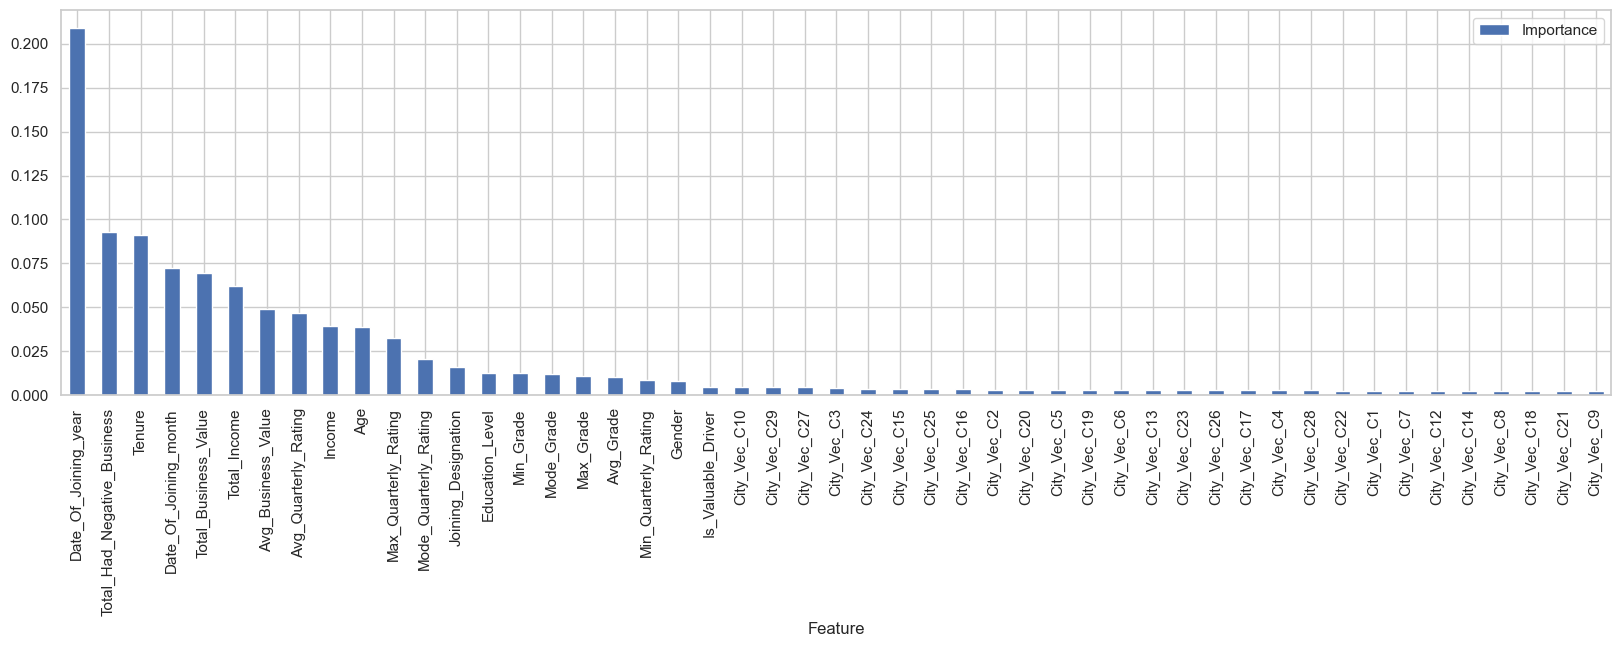

In [18]:
plot_func, _= get_feature_importance(best_rf, model_df)
plot_func();

In [73]:
train_predictions = best_rf.transform(trainingData)
train_f1 = rf_evaluator.evaluate(train_predictions)
print("Train F1 Score = %g" % train_f1)
test_predictions = best_rf.transform(testData)
test_f1 = rf_evaluator.evaluate(test_predictions)
print("Test F1 Score = %g" % test_f1)

Train F1 Score = 0.999491
Test F1 Score = 0.84767


In [ ]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

In [108]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       154
           1       0.86      0.90      0.88       263

    accuracy                           0.85       417
   macro avg       0.84      0.83      0.84       417
weighted avg       0.85      0.85      0.85       417

Accuracy:  0.8489208633093526
F1 Score:  0.88268156424581
AUC:  0.9200162954915806


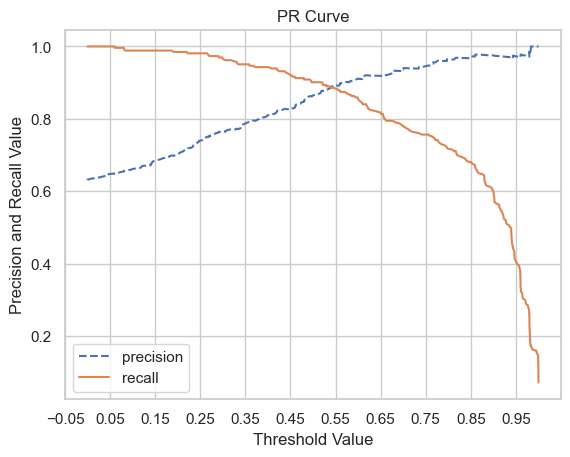

In [100]:
plot_precision_recall_curve(y_true, y_prob)

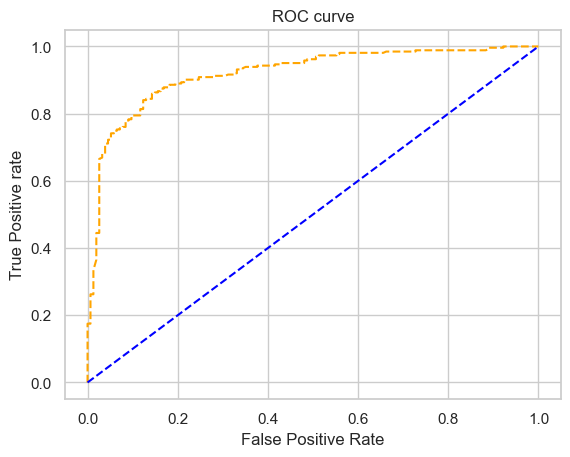

In [101]:
plot_roc_curve(y_true, y_prob)

In [102]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       154
           1       0.86      0.90      0.88       263

    accuracy                           0.85       417
   macro avg       0.84      0.83      0.84       417
weighted avg       0.85      0.85      0.85       417



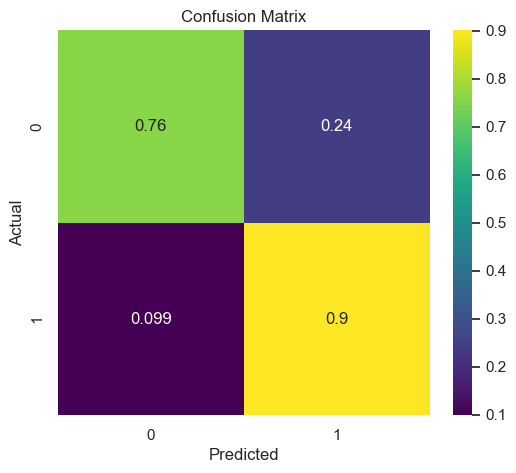

In [103]:
plot_confusion_matrix(y_true, y_pred)

## Gradient Boosting Classifier

In [13]:
gbt = GBTClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42, subsamplingRate=0.8)

In [14]:
paramGrid = ParamGridBuilder()

maxDepth_values = np.random.choice(range(3, 10), size=4, replace=False)
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
stepSize_values =[0.1, 0.2]
maxIter_values = [30, 50, 100, 150]
# subsamplingRate_values = [0.8,1.0]

paramGrid = paramGrid.addGrid(gbt.maxDepth, maxDepth_values) \
                    .addGrid(gbt.maxIter, maxIter_values) \
                    .addGrid(gbt.stepSize, stepSize_values) \
                    .build()

In [15]:
%%time
gbt_cv_model, gbt_evaluator = fit_model(gbt, paramGrid, trainingData, use_train_validation_split=True)

CPU times: user 1.92 s, sys: 792 ms, total: 2.71 s
Wall time: 8min 7s


In [17]:
gbt_best = gbt_cv_model.bestModel
gbt_best.getMaxDepth(), gbt_best.getMaxIter(), gbt_best.getStepSize()

(5, 150, 0.1)

In [44]:
get_all_model_params_tvs(gbt_cv_model).head(5)

,f1,maxDepth,maxIter,stepSize
30,0.940326,5,150,0.1
7,0.940050,9,150,0.2
6,0.937143,9,150,0.1
22,0.934733,4,150,0.1
19,0.934643,4,50,0.2


In [25]:
gbt_cv_model.save("./gbt_cv_model")

In [26]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(gbt_best.transform(testData))

In [19]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       154
           1       0.94      0.92      0.93       263

    accuracy                           0.91       417
   macro avg       0.90      0.91      0.90       417
weighted avg       0.91      0.91      0.91       417

Accuracy:  0.9088729016786571
F1 Score:  0.926923076923077
AUC:  0.9656807071255741


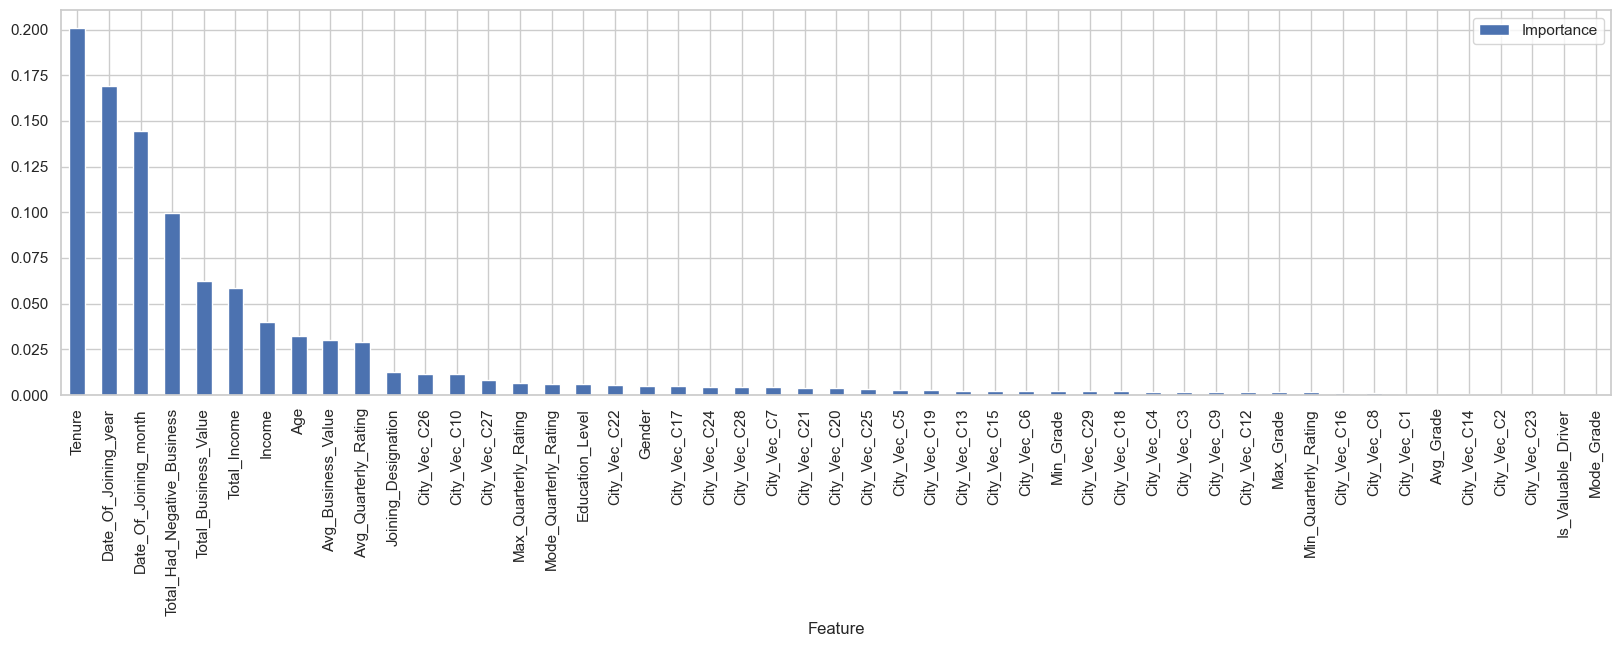

In [20]:
plotfn, _=get_feature_importance(gbt_best, model_df)
plotfn()

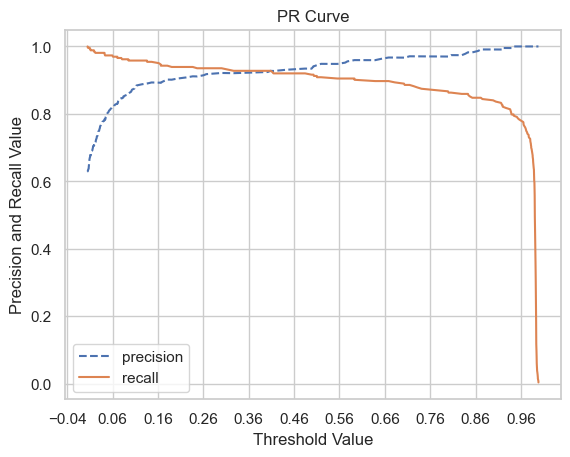

In [21]:
plot_precision_recall_curve(y_true, y_prob)

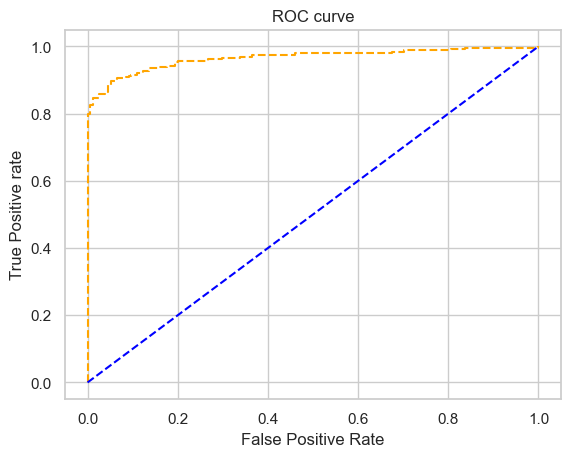

In [22]:
plot_roc_curve(y_true, y_prob)

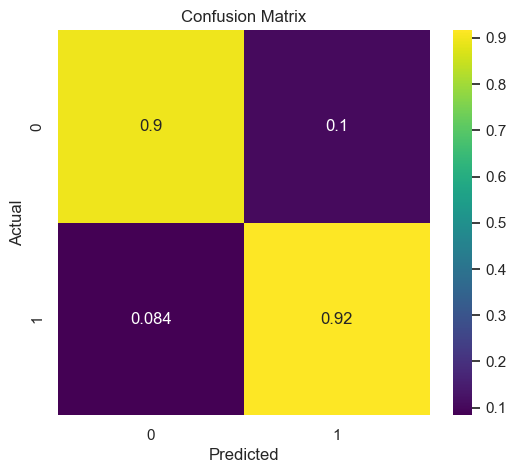

In [23]:
plot_confusion_matrix(y_true, y_pred)

## XGBoost

In [27]:
xgb = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42)
# xgb_feat = SparkXGBClassifier(label_col="Churned", features_col="features", weight_col="classWeightCol", seed=42, max_depth=5, n_estimators=150, learning_rate=0.1, subsample=0.8)

In [63]:
paramGrid = ParamGridBuilder()

maxDepth_values = [3, 5, 7, 10]
# maxBins_values = np.random.choice(range(32, 257), size=5, replace=False)
eta =[0.1, 0.2, 0.3]
num_boosting_rounds_values = [50, 100, 150, 200]
subsample_values = [0.8, 1.0]

paramGrid = paramGrid.addGrid(xgb.max_depth, maxDepth_values) \
                    .addGrid(xgb.learning_rate, eta) \
                    .addGrid(xgb.n_estimators, num_boosting_rounds_values) \
                    .addGrid(xgb.subsample, subsample_values) \
                    .build()

In [64]:
mlflow.set_experiment("XGBoost")

<Experiment: artifact_location='file:///Users/gautamnaik/Documents/Python/OLA_CaseStudy/mlruns/874231119892828675', creation_time=1723657035529, experiment_id='874231119892828675', last_update_time=1723657035529, lifecycle_stage='active', name='XGBoost', tags={}>

In [65]:
xgb_cv_model, xgb_evaluator= fit_model(xgb, paramGrid, trainingData)

2024/08/14 23:07:47 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0c48f07c14f245d48576777c802b1a4c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


2024-08-14 23:07:48,636 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 3, 'objective': 'binary:logistic', 'subsample': 0.8, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-08-14 23:07:48,644 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.2, 'max_depth': 3, 'objective': 'binary:logistic', 'subsample': 1.0, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-08-14 23:07:48,670 INFO XGBoost-PySpark: _fit Running xgboost-2.1.1 on 1 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.2, 'max_depth': 3, 'objective': 'binary:logistic', 'subsample': 0.8, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose

In [79]:
xgb_best = xgb_cv_model.bestModel
type(xgb_best)
# dir(xgb_best)

xgboost.spark.estimator.SparkXGBClassifierModel

In [80]:
xgb_best.save("./xgb_best")

In [78]:
# get best params
get_all_model_params(xgb_cv_model)

,f1,max_depth,learning_rate,n_estimators,subsample
37,0.937843,5,0.2,150,1.0
35,0.936163,5,0.2,100,1.0
43,0.935922,5,0.3,100,1.0
41,0.934990,5,0.3,50,1.0
31,0.933705,5,0.1,200,1.0
...,...,...,...,...,...
2,0.916573,3,0.1,100,0.8
9,0.916193,3,0.2,50,1.0
8,0.910235,3,0.2,50,0.8
0,0.907300,3,0.1,50,0.8


In [83]:
xgb_best.explainParam("max_depth"), xgb_best.explainParam("learning_rate"), xgb_best.explainParam("n_estimators"), xgb_best.explainParam("subsample")

('max_depth: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth (default: None, current: 5)',
 'learning_rate: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate (default: None, current: 0.2)',
 'n_estimators: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators (default: 100, current: 150)',
 'subsample: Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param subsample (default: None, current: 1.0)')

In [67]:
test_predictions = xgb_best.transform(testData)

In [68]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

2024-08-14 23:10:25,300 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs


In [69]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       154
           1       0.96      0.92      0.94       263

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417

Accuracy:  0.9256594724220624
F1 Score:  0.9395711500974658
AUC:  0.9687422843316379


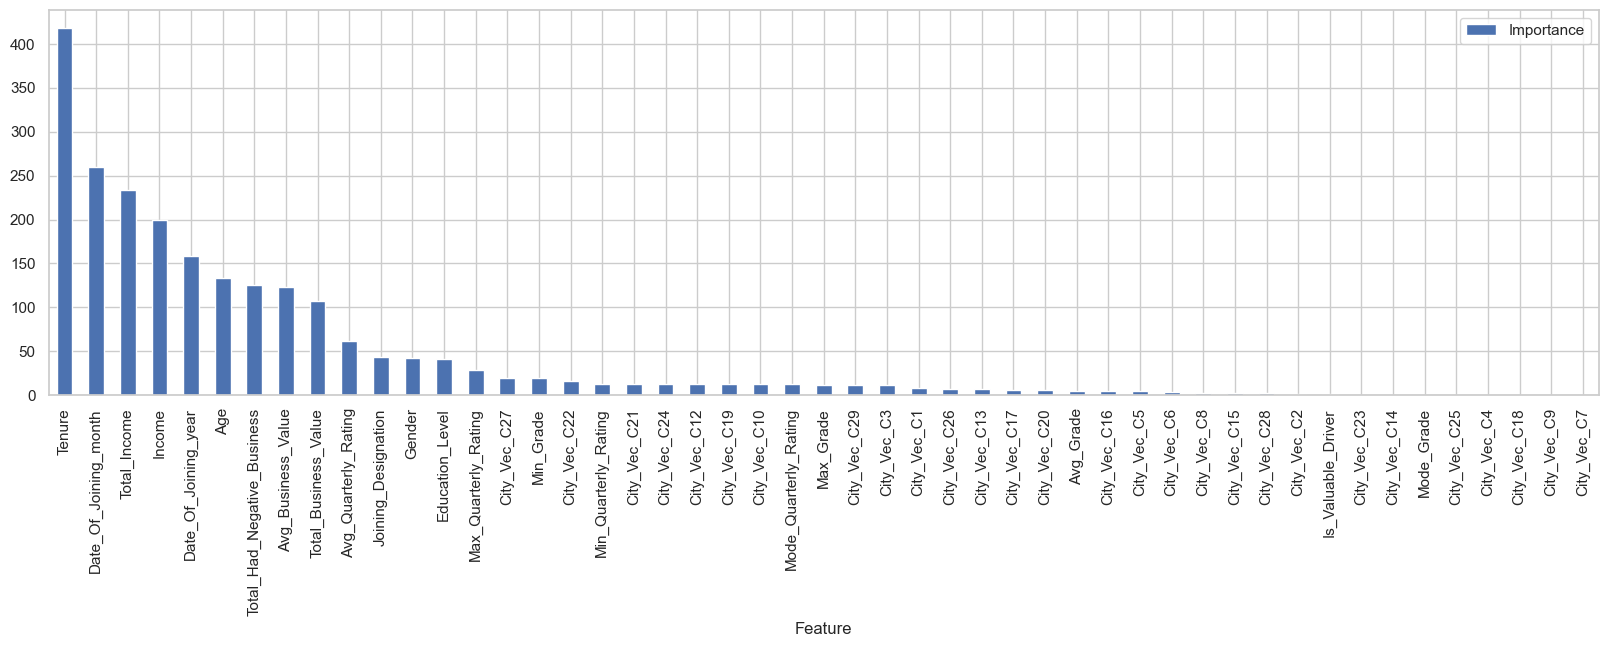

In [70]:
plotfn, _=get_feature_importance_xgboost(xgb_best, model_df)
plotfn()

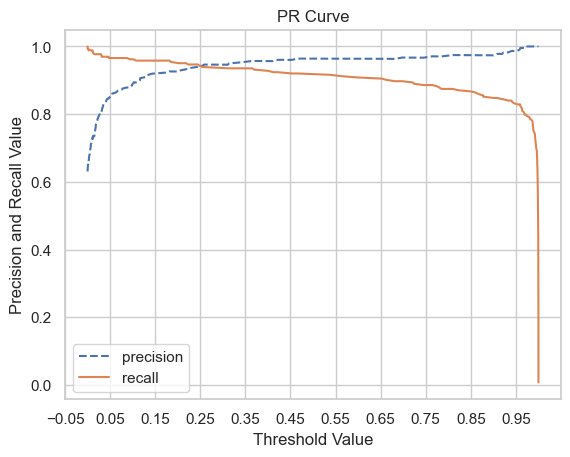

In [71]:
plot_precision_recall_curve(y_true, y_prob)

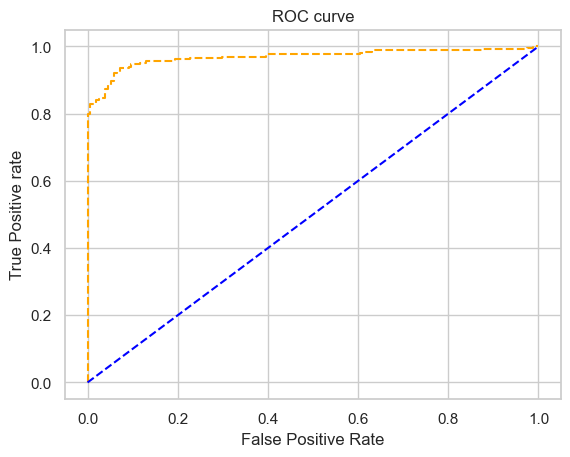

In [72]:
plot_roc_curve(y_true, y_prob)

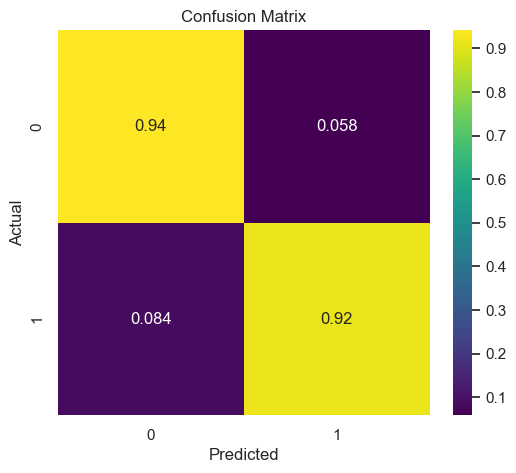

In [73]:
plot_confusion_matrix(y_true, y_pred)

## Light GBM

In [19]:
lgbm = LightGBMClassifier(labelCol="Churned", featuresCol="features", weightCol="classWeightCol", seed=42)

In [13]:
lgbm_model = lgbm.fit(trainingData);

2024/08/15 09:26:44 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3d2800cf0ef54025976795f0a7999be3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pyspark.ml workflow


[LightGBM] [Info] Loaded reference dataset: 49 features, 1964 num_data


2024/08/15 09:27:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/qz/x8fjylv90zxd4l3rz1t0vqp40000gn/T/tmp35er1u36/model, flavor: spark). Fall back to return ['pyspark==3.5.1']. Set logging level to DEBUG to see the full traceback. 


In [21]:
print(lgbm.explainParams())

baggingFraction: Bagging fraction (default: 1.0)
baggingFreq: Bagging frequency (default: 0)
baggingSeed: Bagging seed (default: 3)
binSampleCount: Number of samples considered at computing histogram bins (default: 200000)
boostFromAverage: Adjusts initial score to the mean of labels for faster convergence (default: True)
boostingType: Default gbdt = traditional Gradient Boosting Decision Tree. Options are: gbdt, gbrt, rf (Random Forest), random_forest, dart (Dropouts meet Multiple Additive Regression Trees), goss (Gradient-based One-Side Sampling).  (default: gbdt)
catSmooth: this can reduce the effect of noises in categorical features, especially for categories with few data (default: 10.0)
categoricalSlotIndexes: List of categorical column indexes, the slot index in the features column (default: [])
categoricalSlotNames: List of categorical column slot names, the slot name in the features column (default: [])
catl2: L2 regularization in categorical split (default: 10.0)
chunkSize: A

In [21]:
test_predictions = lgbm_model.transform(testData)

In [22]:
y_true, y_pred, y_prob = spark_prediction_to_numpy(test_predictions)

In [23]:
print_metrics(y_true, y_pred, y_prob)

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       154
           1       0.97      0.92      0.94       263

    accuracy                           0.93       417
   macro avg       0.92      0.93      0.92       417
weighted avg       0.93      0.93      0.93       417

Accuracy:  0.9280575539568345
F1 Score:  0.94140625
AUC:  0.9699521011308083


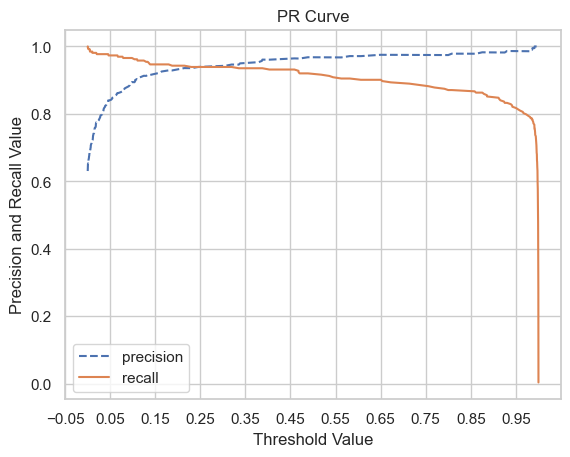

In [24]:
plot_precision_recall_curve(y_true, y_prob)

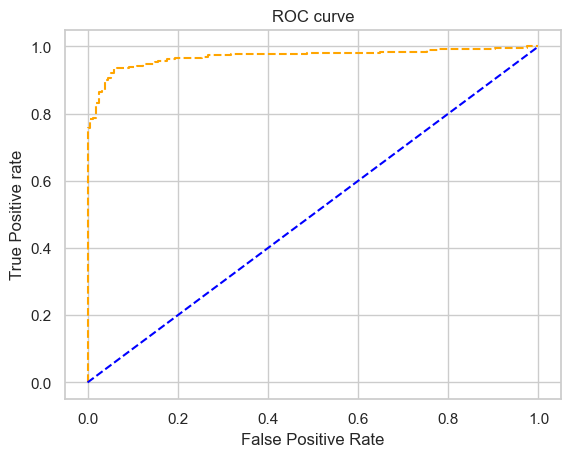

In [25]:
plot_roc_curve(y_true, y_prob)

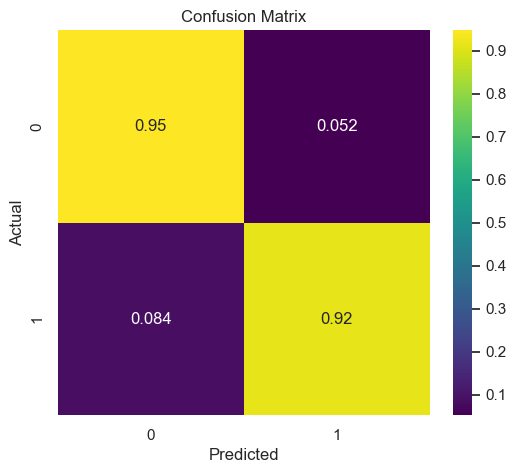

In [26]:
plot_confusion_matrix(y_true, y_pred)

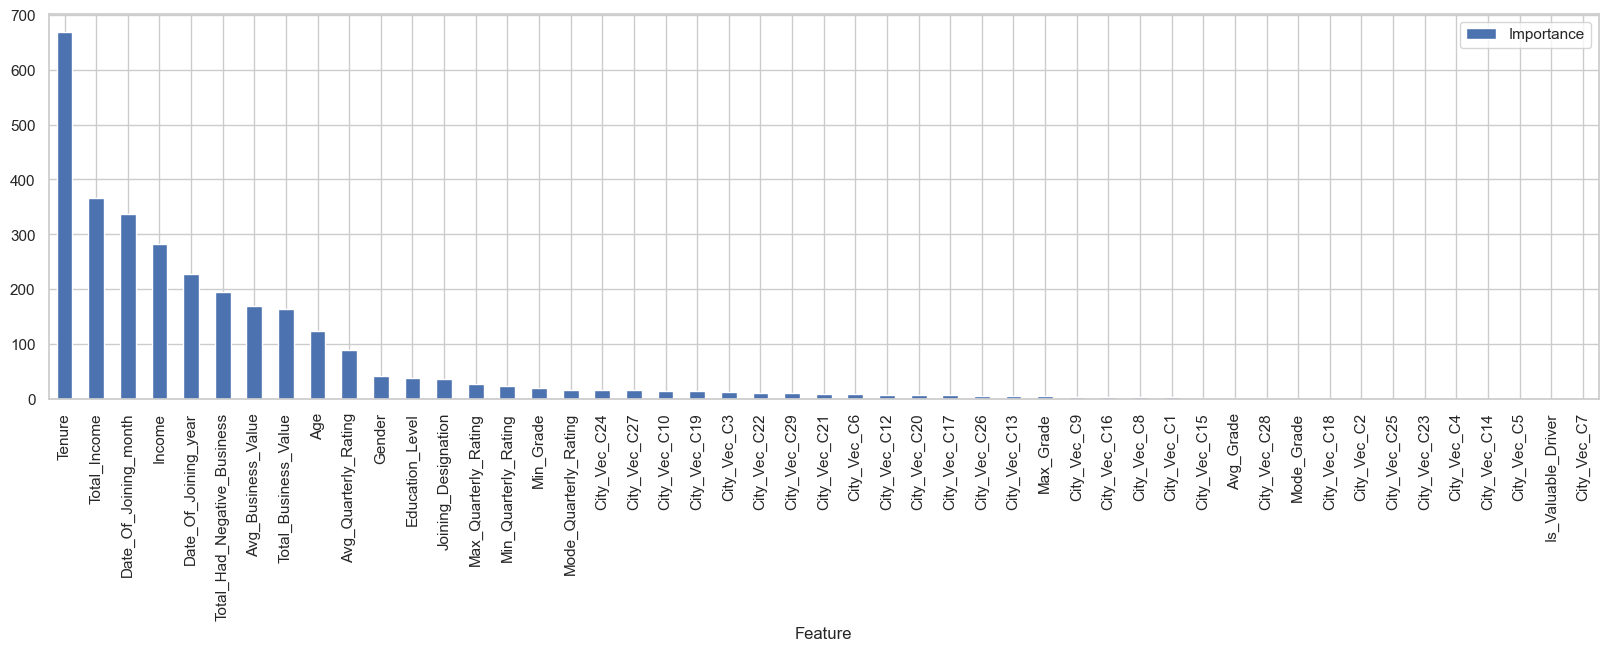

24/08/15 01:56:00 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:123)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:688)
	at org.apache.spark.storage.BlockManagerMasterE

In [33]:
plotfn,_=get_feature_importance_lightgbm(lgbm_model, model_df)
plotfn()

In [96]:
help(LightGBMClassifier)

Help on class LightGBMClassifier in module synapse.ml.lightgbm.LightGBMClassifier:

class LightGBMClassifier(synapse.ml.core.schema.Utils.ComplexParamsMixin, pyspark.ml.util.JavaMLReadable, pyspark.ml.util.JavaMLWritable, pyspark.ml.wrapper.JavaEstimator)
 |  LightGBMClassifier(java_obj=None, baggingFraction=1.0, baggingFreq=0, baggingSeed=3, binSampleCount=200000, boostFromAverage=True, boostingType='gbdt', catSmooth=10.0, categoricalSlotIndexes=[], categoricalSlotNames=[], catl2=10.0, chunkSize=10000, dataRandomSeed=1, dataTransferMode='streaming', defaultListenPort=12400, deterministic=False, driverListenPort=0, dropRate=0.1, dropSeed=4, earlyStoppingRound=0, executionMode=None, extraSeed=6, featureFraction=1.0, featureFractionByNode=None, featureFractionSeed=2, featuresCol='features', featuresShapCol='', fobj=None, improvementTolerance=0.0, initScoreCol=None, isEnableSparse=True, isProvideTrainingMetric=False, isUnbalance=False, labelCol='label', lambdaL1=0.0, lambdaL2=0.0, leafPre